# MOLT Solver Tutorial

This notebook is intended to serve as a tool to demonstrate the coding process for the Method-of-Lines-Transpose (MOLT). Additionally, our document is designed to be entirely self-contained with detailed explanations, supplemented with relevant snippets from publications.  

### Import Packages

In [15]:
# Computing
import numpy as np
from numba import jit
from pylab import meshgrid
from scipy.special import jn, jn_zeros

# Profiling 
import time
import cProfile
import pstats
import io

# Plotting Utilities
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

## MOLT Spatial Discretizations for HJ Equations in 1-D

In MOLT-based schemes, the spatial derivatives are represented as expansions in integral operators, dubbed *successive convolution*. We demonstrate with a discretization of the following HJ equation

\begin{equation}
    u_t + H(x,u_x,t) = 0, \quad u(x,0) = u^{0} (x).
\end{equation}

We assume that the domain consists of a closed interval $[a,b]$ partitioned into $N+1$ points

\begin{equation}
    a = x_0 < x_1 < \cdots < x_{N-1} < x_N = b, 
\end{equation}

and we take $\Delta x_i = x_{i} - x_{i-1}$, so that the mesh can, in principle, be nonuniform. We will let $u(x_i,t) \equiv u_i$ denote the solution to the HJ equation at the mesh point $x_i$ at time $t$. 

We will be constructing the following semi-discrete scheme

\begin{equation}
    \frac{d u_i}{dt} + \hat{H}\left( u_{x,i}^{-},u_{x,i}^{+} \right) = 0, \quad i = 0,1,2, \cdots N,
\end{equation}

where $\hat{H}$ is the *numerical Hamiltonian*. In this work, we use the local Lax-Friedrichs flux

\begin{equation}
    \hat{H}\left( u^{-},u^{+} \right) = H \left( \frac{ u^{-} + u^{+} }{2} \right) - \alpha\left( u^{-},u^{+} \right) \frac{ u^{-} + u^{+} }{2},
\end{equation}

where $ \alpha = \max_{ u^{-} \leq u \leq u^{+} } \lvert H'(u) \rvert $ is the maximum wave propogation speed.

### Approximation of the first order derivative $\partial_x$

In approximating the first derivative, we need to consider the direction of the wave characteristics to ensure stability. We introduce the operators $\mathcal{L}_L$ and $\mathcal{L}_R$ defined by

\begin{align}
    \mathcal{L}_L &= \mathcal{I} + \frac{1}{\gamma}\partial_x \\
    \mathcal{L}_R &= \mathcal{I} - \frac{1}{\gamma}\partial_x,
\end{align}

where $x \in [a,b]$ and $\gamma > 0$ is a constant. Additionally, we have the related operators defined from the $\mathcal{L}$'s

\begin{align}
    \mathcal{D}_L &= \mathcal{I} - \mathcal{L}_{L}^{-1} \\
    \mathcal{D}_R &= \mathcal{I} - \mathcal{L}_{R}^{-1}.
\end{align}

Our goal is to determine an expansion in terms of the $\mathcal{D}$'s using the integrals formed from the respective inversions of $\mathcal{L}_L$ and $\mathcal{L}_R$. We describe this procedure below.



Consider the case with $\mathcal{L}_L$ and $\mathcal{D}_L$ first. Suppose that $w(x)$ is a solution to the differential equation

\begin{equation}
    \mathcal{L}_L [w,\gamma](x) = v(x).
\end{equation}

Then, we can analytically invert $\mathcal{L}_L$ so that

\begin{equation}
    \mathcal{L}_{L}^{-1} [v,\gamma](x) = I^{L} [v,\gamma](x) + A_{L} e^{-\gamma (x-a)},
\end{equation}

where $A_{L}$ is a constant determined via the boundary conditions and

\begin{equation}
    I^{L} [v,\gamma](x) = \gamma \int_{a}^{x}e^{-\gamma (x-y)} v(y) \,dy. 
\end{equation}

Since we are prescribing periodic boundary conditions, we find that

\begin{equation}
    A_{L} = \frac{ I^{L} [v,\gamma](b) }{1 - \mu},
\end{equation}

where

\begin{equation}
    \mu = e^{-\gamma (b-a)}.
\end{equation}

Similarly, for $\mathcal{L}_R$ and $\mathcal{D}_R$, we find that

\begin{equation}
    \mathcal{L}_{R}^{-1} [v,\gamma](x) = I^{R} [v,\gamma](x) + B_{R} e^{-\gamma (b-x)},
\end{equation}

where $B_{R}$ is a constant determined via the boundary conditions and

\begin{equation}
    I^{R} [v,\gamma](x) = \gamma \int_{x}^{b}e^{-\gamma (x-y)} v(y) \,dy. 
\end{equation}


We are now in place to write $\frac{1}{\gamma} \partial_x $ as a series expansion in $\mathcal{D}_{L}$ and $\mathcal{D}_{R}$. To do this, we can write

\begin{equation}
    \frac{1}{\gamma} \partial_x = \mathcal{L}_L - \mathcal{I} = \mathcal{L}_L \left( \mathcal{I} - \mathcal{L}_{L}^{-1} \right) = \frac{ \mathcal{D}_{L} }{ \mathcal{I} - \mathcal{D}_{L}} = \sum_{k=1}^{\infty} \mathcal{D}_{L}^{k} \iff \partial_x = \gamma \sum_{k=1}^{\infty} \mathcal{D}_{L}^{k}.
\end{equation}

Likewise, for the data that propogrates from the right end of the domain, we have that

\begin{equation}
    \frac{1}{\gamma} \partial_x = \mathcal{I} - \mathcal{L}_R = \mathcal{L}_R \left( \mathcal{L}_{R}^{-1} - \mathcal{I} \right) = -\frac{ \mathcal{D}_{R} }{ \mathcal{I} - \mathcal{D}_{R}} = -\sum_{k=1}^{\infty} \mathcal{D}_{R}^{k} \iff \partial_x = -\gamma \sum_{k=1}^{\infty} \mathcal{D}_{R}^{k} .
\end{equation}

We also note the following recursive operations for these operators

\begin{align}
    \mathcal{D}_{L}^{k} &= \mathcal{D}_{L} \left[ \mathcal{D}_{L}^{k-1} \right] \\
    \mathcal{D}_{R}^{k} &= \mathcal{D}_{R} \left[ \mathcal{D}_{R}^{k-1} \right].
\end{align}

Thus, higher order convolution operators are *succesively* defined in terms of lower order operators. 

In truncating the expansions for approximating the first derivatives, we determine how each term effects the error. From a previous paper, it was shown for periodic boundary conditions that the $k$-th partial sum yields a method that is accurate to order $k$ in time. 

### Approximation of the second order derivative $\partial_{xx}$

While the HJ equation we are solving does not include second order spatial derivatives, it can be shown that, for higher order schemes, a "diffusion" term is needed to obtain unconditional stability. To this end, consider the differential operator

\begin{equation}
    \mathcal{L}_{0} = \mathcal{I} - \frac{1}{ \gamma^{2} } \partial_{xx}.
\end{equation}

As before, we assume that $w(x)$ is a solution to the following differential equation

\begin{equation}
    \mathcal{L}_{0}[w,\gamma](x) = v(x).
\end{equation}

We can invert this differential operator analytically to obtain the solution

\begin{equation}
    \mathcal{L}_{0}^{-1} [v,\gamma](x) = \mathcal{I}_{0}[v,\gamma](x) + A_{0} e^{-\gamma(x-a)} + B_{0} e^{-\gamma(b-x)},  
\end{equation}

where

\begin{equation}
    \mathcal{I}_{0}[v,\gamma](x) = \frac{ \gamma }{2} \int_{a}^{b} e^{-\gamma \lvert x-y \rvert } v(y) \,dy.
\end{equation}

For periodic boundary conditions,

\begin{align}
    A_{0} &= \frac{ I^{0} [v,\gamma](b) }{1 - \mu} \\
    B_{0} &= \frac{ I^{0} [v,\gamma](a) }{1 - \mu}
\end{align}

where $\mu$ was previously defined. As in the approximation of $\partial_x$, we can define the related operator

\begin{equation}
    \mathcal{D}_0 = \mathcal{I} - \mathcal{L}_{0}^{-1}
\end{equation}

and write a series expansion for it. If we solve this equation for $\mathcal{L}_{0}^{-1}$, we obtain

\begin{equation}
    \mathcal{L}_0 = \left( \mathcal{I} - \mathcal{D}_{0} \right)^{-1}.
\end{equation}

Then, proceeding as before, we can say

\begin{equation}
    \frac{1}{ \gamma^{2} } \partial_{xx} = \mathcal{I} - \mathcal{L}_0 = \mathcal{L}_0 \left( \mathcal{L}_{0}^{-1} - \mathcal{I} \right) = - \frac{ \mathcal{D}_0 }{ \mathcal{I} - \mathcal{D}_{0} } = - \sum_{k=1}^{\infty} \mathcal{D}_{0}^{k} \iff \partial_{xx} = -\gamma^{2} \sum_{k=1}^{\infty} \mathcal{D}_{0}^{k}.
\end{equation}

As with $\mathcal{D}_{L}^{k}$ and $\mathcal{D}_{R}^{k}$, this convolution operator can be defined *succesively* as

\begin{equation}
    \mathcal{D}_{0}^{k} = \mathcal{D}_{0} \left[ \mathcal{D}_{0}^{k-1} \right].
\end{equation}

In practice, we will need to truncate the expansion for the second derivative. For our purposes, it will be enough to keep only one of the terms in the series. It was previously shown, for periodic boundary conditions, that the inclusion of $\ell$ terms in the partial sum yields a methods that is accurate to order $2\ell$. Thus, for each additional term, we effectively double the order of accuracy (in time). Therefore, we will use

\begin{equation}
    \mathcal{D}_{0}[v,\gamma](x) = v(x) - \frac{ \gamma }{2} \int_{a}^{b} e^{-\gamma \lvert x-y \rvert } v(y) \,dy - + A_{0} e^{-\gamma(x-a)} - B_{0} e^{-\gamma(b-x)}. 
\end{equation}


## Time Integration Methods

For time integratration, we use explicit, strong-stability-preseriving Runge-Kutta (SSP-RK) methods to advance the solution from $t^{n}$ to $t^{n+1}$. Let $u^{n} = u(x,t^{n})$ denote the semi-discrete numerical solution at time $t^{n}$. The SSP-RK methods involve convex combinations of forward euler steps, with high-order accuracy being obtained by choosing constants so that the error terms in the Taylor expansion disappear. In practice, we will couple the $k$-stage SSP-RK method with the $k$-th partial sum of the resolvent expansions to maintain consistency. 

The time integration schemes we will be considering for the HJ equation include the forward Euler scheme

\begin{equation}
    u^{n+1} = u^{n} - \Delta t \hat{H} \left( u_{x}^{-}, u_{x}^{+} \right),
\end{equation}

the two-stage SSP-RK scheme

\begin{align}
    u^{(1)} &= u^{n} - \Delta t \hat{H} \left( u_{x}^{n,-}, u_{x}^{n,+} \right) \\
    u^{n+1} &= \frac{1}{2} u^{n} + \frac{1}{2} \left( u^{(1)} - \Delta t \hat{H} \left( u_{x}^{(1),-}, u_{x}^{(1),+} \right) \right)
\end{align}

and the popular three-stage SSP-RK scheme

\begin{align}
    u^{(1)} &= u^{n} - \Delta t \hat{H} \left( u_{x}^{n,-}, u_{x}^{n,+} \right) \\
    u^{(2)} &= \frac{3}{4} u^{n} + \frac{1}{4} \left( u^{(1)} - \Delta t \hat{H} \left( u_{x}^{(1),-}, u_{x}^{(1),+} \right) \right) \\
    u^{n+1} &= \frac{1}{3} u^{n} + \frac{2}{3} \left( u^{(2)} - \Delta t \hat{H} \left( u_{x}^{(2),-}, u_{x}^{(2),+} \right) \right).
\end{align}

In [16]:
def RK1(u, dt, rhs):
    # Forward Euler update
    u += dt*rhs
    
    return u

def RK2(io, u0, u, dt, rhs):
    if (io==0):
        u = u0 + dt*rhs
    else:
        u = 0.5*u0 + 0.5*(u + dt*rhs)
    
    return u

def RK3(io, u0, u, dt, rhs):
    if (io==0):
        u = u0 + dt*rhs
    elif (io==1):
        u = 3*u0 + 1*(u + dt*rhs)
        u = u/4
    else:
        u = 1*u0 + 2*(u + dt*rhs)
        u = u/3
        
    return u
# @jit
def RK3_bc(io, u0, u, bcu0, bcu, dt, rhs):
    if (io==0):
        u = u0 + dt*rhs
        bcu = bcu + dt
    elif (io==1):
        u = 3*u0 + 1*(u + dt*rhs)
        u = u/4
        bcu = 3/4*bcu0 + 1/4*(bcu + dt)
    else:
        u = 1*u0 + 2*(u + dt*rhs)
        u = u/3
        bcu = 1/3*bcu0 + 2/3*(bcu + dt)
        
    return u, bcu

## General Functions

These are functions that will be called within each of the methods. We have formatted this section so that the  descriptions are followed by the function used to perform desired manipulations.  

### Setting the Time Step

In 1-D, we select the time step at each interation using

\begin{equation*}
    \Delta t = \text{CFL} \frac{ \Delta x }{ \alpha }, 
\end{equation*}

where $\alpha$ is the maximum wave propogation speed and is given by $ \alpha = \max_{u} \lvert H'(u) \rvert. $
Note: We need to compute $\alpha$ at each time step to get the new value for $\Delta t$. The expression for $ H'(u)$ is determined analytically. We compute the time step size using the function below:

In [17]:
def set_dt_AD_2D(t,t_final,CFL,dx,cmax,qmax):
    '''
    This is the function used to compute the time step size dt.

    Input:
    =================================================================
    t: Current time for the integrator.
    t_final: Final time for the integrator.
    CFL: Courant number.
    dx: Spatial step size.
    cmax: Max wave propogation speed depend on f(u).
    qmax: Max wave propogation speed depend on g(u).

    Output:
    =================================================================
    dt: Time step size for the next iteration.
    '''
    dt = CFL * dx / ( cmax + qmax ) / 2

    # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t

    return dt

### WENO Based Quadrature

In order to approximate the local integrals, e.g., $J_{i}^{L} = J^{L} [v,\gamma](x_i)$ in the spatial discretization, we use a fifth order WENO based quadrature. We outline the steps in the fifth order reconstruction for this integral, as the procedure for obtaining $J_{i}^{R}$ is identical.
1. Select three small stencils, denoted as $ S_r (i) = \left\{ x_{i-3+r},x_{i-2+r},x_{i-1+r},x_{i+r} \right\}$, where $ r=0,1,2. $
Then, on each of these stencils, there is an interpolating polynomial $p_r (x)$ of degree at most three, which interpolates $v(x)$ in the stencil $S_r (i)$. Then we can compute
\begin{equation*}
    J_{i,r}^{L} = \gamma \int_{ x_{i-1} }^{ x_{i} } e^{-\gamma (x_i - y)} p_r (y) \,dy  = \sum_{j=0}^{3} c_{i-3+r+j}^{(r)} v_{i-3+r+j}, \quad r=0,1,2,
\end{equation*}
where each $c_{i-3+r+j}^{(r)}$ depends only on $\gamma$ and $\Delta x$.
2. There is a unique polynomial $p(x)$ of degree at most five, which interpolates $v(x)$ in the larger stencil $ S(i) =  \left\{ x_{i-3}, \cdots ,x_{i+2} \right\} $.
Then, we can combine each of our candidates from step 1 by writing
\begin{equation*}
    J_{i,S}^{L} = \gamma \int_{ x_{i-1} }^{ x_{i} } e^{-\gamma (x_i - y)} p_r (y) \,dy  = \sum_{r=0}^{3} d_r J_{i,r}^{L}, 
\end{equation*}
where each $d_r$ is a linear weight.
3. Replace the linear weights with nonlinear weights $\omega_r$ defined as
\begin{equation*}
    \omega_r = \frac{ \tilde{\omega_r} }{ \sum_{s=0}^{2} \tilde{\omega_s} }, \quad r=0,1,2,
\end{equation*}
with 
\begin{equation*}
    \tilde{\omega_r} = \frac{ d_r }{ \epsilon + \beta_r }, \quad r=0,1,2.
\end{equation*}
Here, $\epsilon > 0$ is used to prevent the denominator from becoming zero, and we use $\epsilon = 10^{-6}$ in the experiments. Each $\beta_r$ is a smoothness indicator that is used to measure the relative smoothness of the $v(x)$ in the smaller stencil $S_r (i)$. They are defined by
\begin{align*}
    \beta_0 &= \frac{13}{12}(-v_{i-3} + 3v_{i-2} -3 v_{i-1} + v_i)^2 + \frac{1}{4}(v_{i-3} - 5v_{i-2} +7 v_{i-1} - 3v_i)^2 \\
    \beta_1 &= \frac{13}{12}(-v_{i-2} + 3v_{i-1} -3 v_{i} + v_{i+1})^2 + \frac{1}{4}(v_{i-2} - v_{i-1} + v_{i} + v_{i+1})^2 \\
    \beta_2 &= \frac{13}{12}(-v_{i-1} + 3v_{i} -3 v_{i+1} + v_{i+2})^2 + \frac{1}{4}( -3v_{i-1} + 7v_{i} - 5 v_{i+1} - v_{i+2})^2  \\
\end{align*}
4. Lastly, using the nonlinear weights, approximate $J_{i}^{L}$ by 
\begin{equation*}
    J_{i,W}^{L} = \sum_{r=0}^{2} \omega_r J_{i,r}^{L}. 
\end{equation*}

As a side note, we should write separate routines to perform the left-based and right-based quadrature approximations should we wish to retain more terms in the partial sum. This is a consequence of the successive convolutions. The code to approximate the local integrals is given below. 

In [18]:
# @jit
def ENO_L(v,alpha,dx,bdy_ext,lam):
    '''
    Compute the fifth order WENO-Z quadrature approximation to the
    left convolution integral using a six point global stencil.

    Input:
    =================================================================
    v: A 1-D array for the solution at the time step t_n.
    alpha: Parameter specified by MOLT discretization.
    dx: Grid spacing.
    bdy_ext: A function for boundary extension.

    Output:
    =================================================================
    J_L: A 1-D array for the reconstructed local integrals to the left.
    xi_L: 1-D array of parameters required for the left-based filter.
    '''
    # We need gamma*dx here, so we adjust the value of gamma
    gamma = alpha*dx[1]

    # Get the total number of elements in v
    len_v = v.shape[0]

    # Create the arrays to store the local integrals and the filter data
    J_L = np.zeros((len_v))

    #------------------------------------------------------------------------------------------------------------------
    # Compute the "ENO" weights for the quadrature using the precomputed expressions for the left approximation
    #------------------------------------------------------------------------------------------------------------------

    cl_21 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cl_22 = -( 6 - 2*gamma - 2*gamma**2 - ( 6 + 4*gamma - gamma**2 - 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cl_23 = ( 6 - 4*gamma - gamma**2 + 2*gamma**3 - ( 6 + 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cl_24 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)

    clA_21 = (6+(2-2*lam)*gamma - lam*gamma**2 - (6+(4*lam+2)*gamma + (lam+lam**2)*gamma**2)*np.exp(-lam*gamma))/((lam+2)*(lam+1)*gamma**3)
    clA_22 = -( 6 - 2*lam*gamma - (lam+1)*gamma**2 - ( 6 + 4*lam*gamma +(lam**2-1-lam)*gamma**2 - (lam+lam**2)*gamma**3 )*np.exp(-lam*gamma) )/((lam+1)*lam*gamma**3)
    clA_23 = ( 6 - 4*lam*gamma +(lam**2-lam-1)* gamma**2 + (lam+lam**2)*gamma**3 - ( 6 + 2*lam*gamma - (1+lam)*gamma**2 )*np.exp(-lam*gamma) )/((lam+1)*lam*gamma**3)
    clA_24 = -( 6 - (2+4*lam)*gamma + (lam+lam**2)*gamma**2 - ( 6 +(2*lam-2)*gamma- lam*gamma**2 )*np.exp(-lam*gamma) )/((lam+1)*(lam+2)*gamma**3)

    clC_21 = ( 6 + (2*lam-2)*gamma - lam*gamma**2 - ( 6 + (4+2*lam)*gamma + (1+lam)*gamma**2 )*np.exp(-gamma) )/(2*(lam+2)*gamma**3)
    clC_22 = -( 6 + (2*lam-4)*gamma - 2*lam*gamma**2 - ( 6 + (2*lam+2)*gamma - gamma**2 - (1+lam)*gamma**3 )*np.exp(-gamma) )/((lam+1)*gamma**3)
    clC_23 = ( 6 +(2*lam-6)*gamma +(2-3*lam)* gamma**2 + 2*lam*gamma**3 - ( 6 + 2*lam*gamma - (1+lam)*gamma**2 )*np.exp(-gamma) )/(2*lam*gamma**3)
    clC_24 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(lam*(lam+1)*(lam+2)*gamma**3)

    clB_21 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(lam*(lam+1)*(lam+2)*gamma**3)
    clB_22 = -( 6 - 2*lam*gamma - (lam+1)*gamma**2 - ( 6 + (6-2*lam)*gamma +(2-3*lam)*gamma**2 - 2*lam*gamma**3 )*np.exp(-gamma) )/(2*lam*gamma**3)
    clB_23 = ( 6 - (2+2*lam)*gamma - gamma**2 + (1+lam)*gamma**3 - ( 6 + (4-2*lam)*gamma - 2*lam*gamma**2 )*np.exp(-gamma) )/((lam+1)*gamma**3)
    clB_24 = -( 6 - (4+2*lam)*gamma + (lam+1)*gamma**2 - ( 6 +(2-2*lam)*gamma - lam*gamma**2 )*np.exp(-gamma) )/(2*(lam+2)*gamma**3)


    # Boundary Extension
    bn = 2
    v2 = bdy_ext(v, bn,lam)

    i = bn+1
    J_L[i-bn] = clA_21*v2[i-2] + clA_22*v2[i-1] + clA_23*v2[i  ] + clA_24*v2[i+1]
    
    i = bn+2
    J_L[i-bn] = clB_21*v2[i-2] + clB_22*v2[i-1] + clB_23*v2[i  ] + clB_24*v2[i+1]

    i = len_v + bn - 2
    J_L[i-bn] = clC_21*v2[i-2] + clC_22*v2[i-1] + clC_23*v2[i  ] + clC_24*v2[i+1]

    i = len_v + bn - 1
    J_L[i-bn] = clA_21*v2[i-2] + clA_22*v2[i-1] + clA_23*v2[i  ] + clA_24*v2[i+1]


    for i in range(bn+3,len_v + bn - 2):
        J_L[i-bn] = cl_21*v2[i-2] + cl_22*v2[i-1] + cl_23*v2[i  ] + cl_24*v2[i+1]
    

    return J_L

In [19]:
# @jit
def ENO_R(v,alpha,dx,bdy_ext,lam):
    '''
    Compute the fifth order WENO-Z quadrature approximation to the
    right convolution integral using a six point global stencil.

    Input:
    =================================================================
    v: A 1-D array for the solution at the time step t_n.
    alpha: Parameter specified by MOLT discretization.
    dx: Grid spacing.
    bdy_ext: A function for boundary extension.

    Output:
    =================================================================
    J_R: A 1-D array for the reconstructed local integrals to the right.
    xi_R: 1-D array of parameters required for the right-based filter.
    '''
    # We need gamma*dx here, so we adjust the value of gamma
    gamma = alpha*dx[1]

    # Get the total number of elements in v
    len_v = v.shape[0]

    # Create the arrays to store the local integrals and the filter data
    J_R = np.zeros((len_v))
    xi_R = np.zeros((len_v))

    #------------------------------------------------------------------------------------------------------------------
    # Compute the "ENO" weights for the quadrature using the precomputed expressions for the left approximation
    #------------------------------------------------------------------------------------------------------------------
    cr_24 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cr_23 = -( 6 - 2*gamma - 2*gamma**2 - ( 6 + 4*gamma - gamma**2 - 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cr_22 = ( 6 - 4*gamma - gamma**2 + 2*gamma**3 - ( 6 + 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cr_21 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)

    crA_24 = (6+(2-2*lam)*gamma - lam*gamma**2 - (6+(4*lam+2)*gamma + (lam+lam**2)*gamma**2)*np.exp(-lam*gamma))/((lam+2)*(lam+1)*gamma**3)
    crA_23 = -( 6 - 2*lam*gamma - (lam+1)*gamma**2 - ( 6 + 4*lam*gamma +(lam**2-1-lam)*gamma**2 - (lam+lam**2)*gamma**3 )*np.exp(-lam*gamma) )/((lam+1)*lam*gamma**3)
    crA_22 = ( 6 - 4*lam*gamma +(lam**2-lam-1)* gamma**2 + (lam+lam**2)*gamma**3 - ( 6 + 2*lam*gamma - (1+lam)*gamma**2 )*np.exp(-lam*gamma) )/((lam+1)*lam*gamma**3)
    crA_21 = -( 6 - (2+4*lam)*gamma + (lam+lam**2)*gamma**2 - ( 6 +(2*lam-2)*gamma- lam*gamma**2 )*np.exp(-lam*gamma) )/((lam+1)*(lam+2)*gamma**3)

    crB_24 = ( 6 + (2*lam-2)*gamma - lam*gamma**2 - ( 6 + (4+2*lam)*gamma + (1+lam)*gamma**2 )*np.exp(-gamma) )/(2*(lam+2)*gamma**3)
    crB_23 = -( 6 + (2*lam-4)*gamma - 2*lam*gamma**2 - ( 6 + (2*lam+2)*gamma - gamma**2 - (1+lam)*gamma**3 )*np.exp(-gamma) )/((lam+1)*gamma**3)
    crB_22 = ( 6 +(2*lam-6)*gamma +(2-3*lam)* gamma**2 + 2*lam*gamma**3 - ( 6 + 2*lam*gamma - (1+lam)*gamma**2 )*np.exp(-gamma) )/(2*lam*gamma**3)
    crB_21 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(lam*(lam+1)*(lam+2)*gamma**3)

    crC_24 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(lam*(lam+1)*(lam+2)*gamma**3)
    crC_23 = -( 6 - 2*lam*gamma - (lam+1)*gamma**2 - ( 6 + (6-2*lam)*gamma +(2-3*lam)*gamma**2 - 2*lam*gamma**3 )*np.exp(-gamma) )/(2*lam*gamma**3)
    crC_22 = ( 6 - (2+2*lam)*gamma - gamma**2 + (1+lam)*gamma**3 - ( 6 + (4-2*lam)*gamma - 2*lam*gamma**2 )*np.exp(-gamma) )/((lam+1)*gamma**3)
    crC_21 = -( 6 - (4+2*lam)*gamma + (lam+1)*gamma**2 - ( 6 +(2-2*lam)*gamma - lam*gamma**2 )*np.exp(-gamma) )/(2*(lam+2)*gamma**3)

    bn = 2
    v2 = bdy_ext(v, bn,lam)
   
    i = bn
    J_R[i-bn] = crA_21*v2[i-1] + crA_22*v2[i  ] + crA_23*v2[i+1] + crA_24*v2[i+2]
    
    i = bn + 1
    J_R[i-bn] = crB_21*v2[i-1] + crB_22*v2[i  ] + crB_23*v2[i+1] + crB_24*v2[i+2]

    i = len_v + bn - 3
    J_R[i-bn] = crC_21*v2[i-1] + crC_22*v2[i  ] + crC_23*v2[i+1] + crC_24*v2[i+2]
    
    i = len_v + bn - 2
    J_R[i-bn] = crA_21*v2[i-1] + crA_22*v2[i  ] + crA_23*v2[i+1] + crA_24*v2[i+2]
    
    for i in range(bn+2,len_v-3+bn):
        J_R[i-bn] = cr_21*v2[i-1] + cr_22*v2[i  ] + cr_23*v2[i+1] + cr_24*v2[i+2]


    return J_R

### The Nonlinear Filters

We construct the nonlinear filters using the smoothness indicators from the WENO routine. First, we define

\begin{equation}
    \tau_5 := \lvert \beta_0 - \beta_2 \rvert, 
\end{equation}

which is the absolute difference in the smoothness of the stencils. Then, we define a parameter 

\begin{equation}
    \xi_i := \frac{ \beta_{\text{min}} }{ \beta_{\text{max}} }, 
\end{equation}

which is used in the construction of the filter. We also have the following definitions for $\beta_{\text{min}}$ and $\beta_{\text{max}}$:

\begin{equation}
    \beta_{\text{min}}:= 1 + \left( \frac{ \tau_5 }{ \epsilon + \min (\beta_0,\beta_2) }  \right)^{2}, \quad \beta_{\text{max}}:= 1 + \left( \frac{ \tau_5 }{ \epsilon + \max (\beta_0,\beta_2) }  \right)^{2}.
\end{equation}

Finally, the filters are determined by

\begin{equation}
    \sigma_{i,L}:= \min (\xi_{i-1},\xi_{i}) , \quad \sigma_{i,R}:= \min (\xi_{i},\xi_{i+1}).
\end{equation}

The explicit form of the schemes using these filters will be presented above the relevant snippets of code.


### Outline of the Fast Convolution Algorithm

In this section, we describe spatial approximations for the operators $\mathcal{D}_{L}$ and $\mathcal{D}_{R}$. We will employ a "trick" to obtain $\mathcal{I}_{0}$ in $\mathcal{D}_{0}$. Recall that

\begin{align}
    \mathcal{D}_L &= \mathcal{I} - \mathcal{L}_{L}^{-1} \\
    \mathcal{D}_R &= \mathcal{I} - \mathcal{L}_{R}^{-1},
\end{align}

where 

\begin{align}
    \mathcal{L}_{L}^{-1} [v,\gamma](x) &= I^{L} [v,\gamma](x) + A_{L} e^{-\gamma (x-a)} \\
    \mathcal{L}_{R}^{-1} [v,\gamma](x) &= I^{R} [v,\gamma](x) + B_{R} e^{-\gamma (b-x)},
\end{align}

and $I^{L} [v,\gamma](x)$ and $I^{R} [v,\gamma](x)$ are convolution integrals. The fast convolution only needs to be applied to $I^{L}$ and $I^{R}$, as the remaining terms can be evaluated directly. Therefore, we focus only on the convolution integrals. 

We proceed by letting $I^{\ast} [v,\gamma](x_i) = I_{i}^{\ast}$ at each grid point, with $\ast$ being $L$ and $R$. Then, we have the following recursive relation

\begin{align}
    I_{i}^{L} &= e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}, \quad i = 1, \cdots, N \\
    I_{i}^{R} &= e^{-\gamma \Delta x_i } I_{i-1}^{R} + J_{i}^{R}, \quad i = 0, \cdots, N-1, 
\end{align}

where 

\begin{equation}
    J_{i}^{L} = \gamma \int_{x_{i-1}}^{x_i} e^{-\gamma (x_i -y)} v(y) \,dy, \quad J_{i}^{R} = \gamma \int_{x_{i}}^{x_{i+1}} e^{-\gamma (y- x_i)} v(y) \,dy
\end{equation}

are the *local integrals*. A high-order WENO based quadrature is used to discretize each of these local integrals. 

The pseudo-code for the evaluating the integrals is as follows:
1. Set $I_{0}^{L} = 0$ and $I_{N}^{R} = 0$.
2. Compute each of the local integrals $J_{i}^{L}$ and $J_{i}^{R}$ using WENO quadrature. 
3. "Sweep" across the domain from left to right via $I_{i}^{L} = e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}$. At the end of each iterate, set $i \mapsto i+1$.
4. "Sweep" across the domain from right to left via $I_{i}^{R} = e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}$. At the end of each iterate, set $i \mapsto i-1$.
5. If the second derivative is needed, compute $I_{0,i} = \frac{1}{2} \left( I_{i}^{L} + I_{i}^{R} \right)$. 

The special feature of this recursive relation is that it allows the convolution algorithm to be evaluated using $\mathcal{O}(N)$ operations, rather than a direct method, which would require $\mathcal{O}(N^2)$ operations. Additionally, each of these local integrals, as well as the sweeps, can be evaluted in parallel. 

In [20]:
# @jit
def fast_convolution(J_L,J_R,gamma,dx):
    '''
    This function computes the value of the covolution integral
    at the grid points using a fast-summation algorithm, previously
    descibed.

    Input:
    =================================================================
    J_L: A 1-D array for the local integrals on the left.
    J_R: A 1-D array for the local integrals on the right.
    gamma: The MOLT parameter related to the time step.
    dx: Grid spacing.

    Output:
    =================================================================
    I_L: A 1-D array for the left convolution integral at the grid points
    I_R: A 1-D array for the right convolution integral at the grid points
    '''

    # Initialize the arrays to store the solutions
    N = J_L.shape[0] - 1
    I_L = np.zeros((N+1))
    I_R = np.zeros((N+1))

    for i in range(1,N+1):

        # Perform the sweeps to the right
        I_L[i] = np.exp( -gamma*dx[i-1] )*I_L [i-1] + J_L[i]

        # Perform the sweeps to the left
        j = N - i
        I_R[j] = np.exp( -gamma*dx[j] )*I_R [j+1] + J_R[j]

    return I_L, I_R

### Computing the Inverse Operators

For the case of periodic boundary conditions, we will require

\begin{align*}
    \mathcal{D}_{L}^{k}(a) &= \mathcal{D}_{L}^{k}(b), \quad k = 0,1,2, \cdots \\
    \mathcal{D}_{R}^{k}(a) &= \mathcal{D}_{R}^{k}(b), \quad k = 0,1,2, \cdots \\
    \mathcal{D}_{0}(a) &= \mathcal{D}_{0}(b). 
\end{align*}

We write a total of three routines: one each for dealing with the left and right BCs, and a third for the boundary conditions when the diffusion term is required. We will also be constructing the inverse operators here using the results from the fast convolution routine. These inverse operators are constructed via

\begin{align}
    \mathcal{L}_{L}^{-1} [v,\gamma](x) &= I^{L} [v,\gamma](x) + A_{L} e^{-\gamma (x-a)} \\
    \mathcal{L}_{R}^{-1} [v,\gamma](x) &= I^{R} [v,\gamma](x) + B_{R} e^{-\gamma (b-x)}.
\end{align}

with the constants $A_{L}$ and $B_{R}$ being determined by the periodic BCs. Similarly, for the diffusion term

\begin{equation}
    \mathcal{L}_{0}^{-1} [v,\gamma](x) = \mathcal{I}_{0}[v,\gamma](x) + A_{0} e^{-\gamma(x-a)} + B_{0} e^{-\gamma(b-x)},  
\end{equation}

with constants being determined via periodic boundary conditions.


In [21]:
def diff_inversion(I_0,x,gamma,A,B):
    '''
    This function constructs the left going inverse of L using the
    data from the boundary conditions, which we take to be NON periodic.

    Input:
    =================================================================
    I_L: A 1-D array for the left convolution integral
    I_R: A 1-D array for the right convolution integral
    x: 1-D array containing the locations of the N+1 grid points.
    gamma: The MOLT parameter related to the time step.
    A:Get them by using the general boundary setting, in practice, we may need
    B:Get them by using the general boundary setting

    Output:
    =================================================================
    I_0: A 1-D array for the inverse of the operator L_0
    '''
    # Now construct L_0inv through summation
    for i in range(x.size):

        I_0[i] += A*np.exp(-gamma*( x[i] - x[0] )) + B*np.exp(-gamma*( x[-1] - x[i] ))

    return I_0

In [22]:
def get_boundary_dir_xx(I_0,v,x,gamma,dx,C_a,C_b):
    '''
    Dirichlet boundary

    Input:
    =================================================================
    v1/v2: 1-D array containing the left and right boundary points.
    dx: Grid spacing.

    Output:
    =================================================================
    A/B: left/right boundary approximation for the updated solution at the next time step
    '''

    BC_a = I_0[0]-v[0]+C_a
    BC_b = I_0[-1]-v[-1]+C_b

    mu = np.exp(-gamma*( x[-1] - x[0] ) )

    A = (mu*BC_b-BC_a)/(1 - mu**2)
    B = (mu*BC_a-BC_b)/(1 - mu**2)


    return A, B

In [23]:
def molt_xx(u,x,gamma,dx,C_a,C_b,bdy_ext,lam):

    # Get the local integrals using the WENO quadrature
    # J_L = WENO_L(u,gamma,dx,bdy_ext)
    # J_R = WENO_R(u,gamma,dx,bdy_ext)
    # J_L,J_R = integral_test_1(u,u,gamma,dx,bdy_ext)
    J_L = ENO_L(u,gamma,dx,bdy_ext,lam)
    J_R = ENO_R(u,gamma,dx,bdy_ext,lam)

    # Perform the fast summation to get the convolution integrals
#     I_L, I_R = fast_convolution(J_L,J_R,gamma,dx)
    I_L, I_R = fast_convolution(J_L,J_R,gamma,dx)
    I_0 = 0.5*(I_L+I_R)

    # Use the left/right BC to get boundary terms
    A, B = get_boundary_dir_xx(I_0,u,x,gamma,dx,C_a,C_b)

    # Get L_0inv
    L_0inv = diff_inversion(I_0,x,gamma,A,B)

    return L_0inv

## Numerical Examples

We examine the performance of the described schemes on several test problems. Each section of code for computing the solution to an example is intended to be a different instance. 

### 1-D Example: Problem 1

We demonstrate the method on the 1-D Burger's equation:

\begin{equation*}
     u_t + \frac{1}{2} \left( u_x + 1 \right)^{2} = 0, \quad -1 \leq x \leq 1, \quad t \in [0,1]
\end{equation*}

subject to the initial condition (IC)

\begin{equation*}
     u(x,0) = -\cos (\pi x).
\end{equation*}

This implementation also uses periodic boundary conditions (BCs) so that

\begin{equation*}
    u(-1,t) = u(1,t), \quad u_x (-1,t) = u_x (1,t)
\end{equation*}
hold.

### First Order Scheme

For the first order scheme, we use only the first term in the partial sums for the first order derivatives:

\begin{align}
    u_{x}^{-}(x) &\approx \gamma \mathcal{D}_{L} [u,\gamma](x) \\
    u_{x}^{+}(x) &\approx -\gamma \mathcal{D}_{R} [u,\gamma](x). 
\end{align}


### Third Order Scheme

The case for the third order scheme is similar to the above for the second order case. We modify the original scheme to give only three constributions from the partial sum. These modifications involve applications of the nonlinear filters $\sigma_{L}$ and $\sigma_{R}$ to tame highly oscillatory contributions from $\mathcal{D}_{L}^{k}$ and $\mathcal{D}_{R}^{k}$, where $k \geq 2$. The resulting scheme is

\begin{align}
    u_{x}^{-}(x) &\approx \gamma \mathcal{D}_{L} [u,\gamma](x) + \gamma \sigma_{L} \mathcal{D}_{L}^{2} [u,\gamma](x) + \gamma \sigma_{L}^{2} \mathcal{D}_{L}^{3} [u,\gamma](x) \\
    u_{x}^{+}(x) &\approx -\gamma \mathcal{D}_{R} [u,\gamma](x) - \gamma \sigma_{R} \mathcal{D}_{R}^{2} [u,\gamma](x) - \gamma \sigma_{R}^{2} \mathcal{D}_{R}^{3} [u,\gamma](x). 
\end{align}

Note that we no longer have the diffusion terms involving $\mathcal{D}_{0}$, which were previously required to maintain stability.

In [24]:
# @jit
def MOLT1_dir_xx(U,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,cmax,t,v2x):
    # Initialize an array to store the RHS
    N = x.shape[0] -1
    Nc = int(N/2)
    
    rhs = np.zeros((N+1,N+1))
    u_xx = np.zeros((N+1,N+1))
    u_yy = np.zeros((N+1,N+1))

    gamma = np.sqrt(beta/(cmax*dt))
    
    for j in range(N+1):
        u0 = U[:, j]
        
        ## mesh-line-setting
        n = int(xn_id[j])
        p = np.zeros(2*n+1)
        u = np.zeros(2*n+1)
        k=0
        for i in range(Nc-n, Nc+n+1):
            p[k]=x[i]
            u[k]=u0[i]
            k+=1
            
        if xn_dx[j]==0:
            U[Nc-n,j]=0
            U[Nc+n,j]=0
        else:
            #if xn_dx[j]!=0:    
            n=n+1
            p2 = np.zeros(2*n+1)
            u2 = np.zeros(2*n+1)   
            p2[1:-1] = p
            u2[1:-1] = u
            p2[ 0] = p[ 0] - xn_dx[j]
            p2[-1] = p[-1] + xn_dx[j]
            p = p2
            u = u2
        u[ 0] = 0
        u[-1] = 0   
        if n==0:
            dp = np.zeros(1)
        else:
            dp = p[1:]-p[0:-1]
        ##
        

        if n!=0:
            lam = dp[0]/dp[1]
            C_a = -v2x(p[0],t)/gamma**2
            C_b = -v2x(p[-1],t)/gamma**2
            L_diff = molt_xx(g(u),p,gamma,dp,C_a,C_b,bdy_ext,lam)
        
            # Construct the left/right derivative with the definition of D_L/D_R
            D_c = g(u) - L_diff
            u_xx[Nc-n:Nc+n+1,j] = -gamma**2*(D_c).transpose()
                   
    for i in range(0,N+1):
        
        u0 = U[i,:]
            
        n = int(yn_id[i])
        p = np.zeros(2*n+1)
        u = np.zeros(2*n+1)
        k=0
        for j in range(Nc-n, Nc+n+1):
            p[k]=y[j]
            u[k]=u0[j]
            k += 1
        if yn_dy[i]!=0:
            n=n+1
            p2 = np.zeros(2*n+1)
            u2 = np.zeros(2*n+1)   
            p2[1:-1] = p
            u2[1:-1] = u
            p2[ 0] = p[ 0] - yn_dy[i]
            p2[-1] = p[-1] + yn_dy[i]
            p = p2
            u = u2
        
        u[ 0] = 0
        u[-1] = 0        
        if n==0:
            dp = np.zeros(1)
        else:
            dp = p[1:]-p[0:-1]
        
        
        if n!=0 :
            lam = dp[0]/dp[1]
            C_a = -v2x(p[0],t)/gamma**2
            C_b = -v2x(p[-1],t)/gamma**2
            L_diff = molt_xx(g(u),p,gamma,dp,C_a,C_b,bdy_ext,lam)
        
            D_c = g(u) - L_diff
            u_yy[i,Nc-n:Nc+n+1] = -gamma**2*(D_c).transpose()
    
    
    # Build the RHS
    
    for j in range(0,N+1):
        for i in range(0,N+1):
            r2 = x[i]**2 + y[j]**2
            if (r2 >= 1):
                u_xx[i][j] = v2x(x[i],t)
                u_yy[i][j] = v2x(y[j],t)
                
    # Max wave speed from the current solution used in the LxF splitting
    
    rhs = u_xx + u_yy


    return rhs


In [25]:
# @jit
def MOLT2_dir_xx(U,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,cmax,t,v2x,v4x,io):
    # Initialize an array to store the RHS
    if io == 1:
        t = t+dt
        
    N = x.shape[0] -1
    Nc = int(N/2)
    
    rhs = np.zeros((N+1,N+1))
    u_xx = np.zeros((N+1,N+1))
    u_yy = np.zeros((N+1,N+1))

    gamma = np.sqrt(beta/(cmax*dt))
    
    for j in range(N+1):
        u0 = U[:, j]
        
        ## mesh-line-setting
        n = int(xn_id[j])
        p = np.zeros(2*n+1)
        u = np.zeros(2*n+1)
        k=0
        for i in range(Nc-n, Nc+n+1):
            p[k]=x[i]
            u[k]=u0[i]
            k+=1
            
        if xn_dx[j]==0:
            U[Nc-n,j]=0
            U[Nc+n,j]=0
        else:
            #if xn_dx[j]!=0:    
            n=n+1
            p2 = np.zeros(2*n+1)
            u2 = np.zeros(2*n+1)   
            p2[1:-1] = p
            u2[1:-1] = u
            p2[ 0] = p[ 0] - xn_dx[j]
            p2[-1] = p[-1] + xn_dx[j]
            p = p2
            u = u2
        u[ 0] = 0
        u[-1] = 0   
        if n==0:
            dp = np.zeros(1)
        else:
            dp = p[1:]-p[0:-1]
        ##
        
        
        if n!=0:
            mu = np.exp(-gamma*( p[-1] - p[0] ) )
            lam = dp[0]/dp[1]
            C_a = -v2x(p[0],t)/gamma**2
            C_b = -v2x(p[-1],t)/gamma**2
            L_diff = molt_xx(g(u),p,gamma,dp,C_a,C_b,bdy_ext,lam)
        
            # Construct the left/right derivative with the definition of D_L/D_R
            D_c = g(u) - L_diff
            u_xx[Nc-n:Nc+n+1,j] = -gamma**2*(D_c).transpose()
            
            A =  1/gamma**4/(1-mu**2)*(mu*v4x(p[-1],t)-v4x(p[0],t))
            B =  1/gamma**4/(1-mu**2)*(mu*v4x(p[0],t)-v4x(p[-1],t))
            D_c = diff_inversion(D_c,p,gamma,A,B) #D_0-modify
            
            L_diff = molt_xx(D_c,p,gamma,dp,0,0,bdy_ext,lam)
        
            # Construct the left/right derivative with the definition of D_L/D_R
            D2_c = D_c - L_diff
            u_xx[Nc-n:Nc+n+1,j] += -gamma**2*(D2_c).transpose()
                   
    for i in range(0,N+1):
        
        u0 = U[i,:]
            
        n = int(yn_id[i])
        p = np.zeros(2*n+1)
        u = np.zeros(2*n+1)
        k=0
        for j in range(Nc-n, Nc+n+1):
            p[k]=y[j]
            u[k]=u0[j]
            k += 1
        if yn_dy[i]!=0:
            n=n+1
            p2 = np.zeros(2*n+1)
            u2 = np.zeros(2*n+1)   
            p2[1:-1] = p
            u2[1:-1] = u
            p2[ 0] = p[ 0] - yn_dy[i]
            p2[-1] = p[-1] + yn_dy[i]
            p = p2
            u = u2
        
        u[ 0] = 0
        u[-1] = 0        
        if n==0:
            dp = np.zeros(1)
        else:
            dp = p[1:]-p[0:-1]
        
        
        if n!=0 :
            lam = dp[0]/dp[1]
            C_a = -v2x(p[0],t)/gamma**2
            C_b = -v2x(p[-1],t)/gamma**2
            L_diff = molt_xx(g(u),p,gamma,dp,C_a,C_b,bdy_ext,lam)
        
            D_c = g(u) - L_diff
            u_yy[i,Nc-n:Nc+n+1] = -gamma**2*(D_c).transpose()
            
            A =  1/gamma**4/(1-mu**2)*(mu*v4x(p[-1],t)-v4x(p[0],t))
            B =  1/gamma**4/(1-mu**2)*(mu*v4x(p[0],t)-v4x(p[-1],t))
            D_c = diff_inversion(D_c,p,gamma,A,B) #D_0-modify
            
            L_diff = molt_xx(D_c,p,gamma,dp,0,0,bdy_ext,lam)
        
            # Construct the left/right derivative with the definition of D_L/D_R
            D2_c = D_c - L_diff
            u_yy[i,Nc-n:Nc+n+1] += -gamma**2*(D2_c).transpose()
    
    
    # Build the RHS
    
    for j in range(0,N+1):
        for i in range(0,N+1):
            r2 = x[i]**2 + y[j]**2
            if (r2 > 1):
                u_xx[i][j] = v2x(x[i],t)
                u_yy[i][j] = v2x(y[j],t)
                
    # Max wave speed from the current solution used in the LxF splitting
    
    rhs = u_xx + u_yy


    return rhs


In [26]:
# @jit
def MOLT3_dir_xx(U,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,cmax,t,v2x,v4x,v6x,io):
    # Initialize an array to store the RHS
    if io == 1:
        t = t+dt
    if io == 2:
        t = t+0.5*dt
        
    N = x.shape[0] -1
    Nc = int(N/2)
    
    rhs = np.zeros((N+1,N+1))
    u_xx = np.zeros((N+1,N+1))
    u_yy = np.zeros((N+1,N+1))

    gamma = np.sqrt(beta/(cmax*dt))
    
    for j in range(N+1):
        u0 = U[:, j]
        
        ## mesh-line-setting
        n = int(xn_id[j])
        p = np.zeros(2*n+1)
        u = np.zeros(2*n+1)
        k=0
        for i in range(Nc-n, Nc+n+1):
            p[k]=x[i]
            u[k]=u0[i]
            k+=1
            
        if xn_dx[j]==0:
            U[Nc-n,j]=0
            U[Nc+n,j]=0
        else:
            #if xn_dx[j]!=0:    
            n=n+1
            p2 = np.zeros(2*n+1)
            u2 = np.zeros(2*n+1)   
            p2[1:-1] = p
            u2[1:-1] = u
            p2[ 0] = p[ 0] - xn_dx[j]
            p2[-1] = p[-1] + xn_dx[j]
            p = p2
            u = u2
        u[ 0] = 0
        u[-1] = 0   
        if n==0:
            dp = np.zeros(1)
        else:
            dp = p[1:]-p[0:-1]
        ##
        
        
        if n!=0:
            mu = np.exp(-gamma*( p[-1] - p[0] ) )
            lam = dp[0]/dp[1]
            C_a = -v2x(p[0],t)/gamma**2
            C_b = -v2x(p[-1],t)/gamma**2
            L_diff = molt_xx(g(u),p,gamma,dp,C_a,C_b,bdy_ext,lam)
        
            # Construct the left/right derivative with the definition of D_L/D_R
            D_c = g(u) - L_diff
            u_xx[Nc-n:Nc+n+1,j] = -gamma**2*(D_c).transpose()
            
            A =  1/gamma**4/(1-mu**2)*(mu*v4x(p[-1],t)-v4x(p[0],t))+1/gamma**6/(1-mu**2)*(mu*v6x(p[-1],t)-v6x(p[0],t))
            B =  1/gamma**4/(1-mu**2)*(mu*v4x(p[0],t)-v4x(p[-1],t))+1/gamma**6/(1-mu**2)*(mu*v6x(p[0],t)-v6x(p[-1],t))
            D_c = diff_inversion(D_c,p,gamma,A,B) #D_0-modify
            
            L_diff = molt_xx(D_c,p,gamma,dp,0,0,bdy_ext,lam)
        
            # Construct the left/right derivative with the definition of D_L/D_R
            D2_c = D_c - L_diff
            u_xx[Nc-n:Nc+n+1,j] += -gamma**2*(D2_c).transpose()


            A =  -1/gamma**4/(1-mu**2)*(mu*v4x(p[-1],t)-v4x(p[0],t))-2/gamma**6/(1-mu**2)*(mu*v6x(p[-1],t)-v6x(p[0],t))
            B =  -1/gamma**4/(1-mu**2)*(mu*v4x(p[0],t)-v4x(p[-1],t))-2/gamma**6/(1-mu**2)*(mu*v6x(p[0],t)-v6x(p[-1],t))

            D2_c = diff_inversion(D2_c,p,gamma,A,B) #D_0-modify

            L_diff = molt_xx(D2_c,p,gamma,dp,0,0,bdy_ext,lam)
            
            D3_c = D2_c - L_diff
            u_xx[Nc-n:Nc+n+1,j] += -gamma**2*(D3_c).transpose()
                   
    for i in range(0,N+1):
        
        u0 = U[i,:]
            
        n = int(yn_id[i])
        p = np.zeros(2*n+1)
        u = np.zeros(2*n+1)
        k=0
        for j in range(Nc-n, Nc+n+1):
            p[k]=y[j]
            u[k]=u0[j]
            k += 1
        if yn_dy[i]!=0:
            n=n+1
            p2 = np.zeros(2*n+1)
            u2 = np.zeros(2*n+1)   
            p2[1:-1] = p
            u2[1:-1] = u
            p2[ 0] = p[ 0] - yn_dy[i]
            p2[-1] = p[-1] + yn_dy[i]
            p = p2
            u = u2
        
        u[ 0] = 0
        u[-1] = 0        
        if n==0:
            dp = np.zeros(1)
        else:
            dp = p[1:]-p[0:-1]
        
        
        if n!=0 :
            lam = dp[0]/dp[1]
            C_a = -v2x(p[0],t)/gamma**2
            C_b = -v2x(p[-1],t)/gamma**2
            L_diff = molt_xx(g(u),p,gamma,dp,C_a,C_b,bdy_ext,lam)
        
            D_c = g(u) - L_diff
            u_yy[i,Nc-n:Nc+n+1] = -gamma**2*(D_c).transpose()
            
            A =  1/gamma**4/(1-mu**2)*(mu*v4x(p[-1],t)-v4x(p[0],t))+1/gamma**6/(1-mu**2)*(mu*v6x(p[-1],t)-v6x(p[0],t))
            B =  1/gamma**4/(1-mu**2)*(mu*v4x(p[0],t)-v4x(p[-1],t))+1/gamma**6/(1-mu**2)*(mu*v6x(p[0],t)-v6x(p[-1],t))
            D_c = diff_inversion(D_c,p,gamma,A,B) #D_0-modify
            
            L_diff = molt_xx(D_c,p,gamma,dp,0,0,bdy_ext,lam)
        
            # Construct the left/right derivative with the definition of D_L/D_R
            D2_c = D_c - L_diff
            u_yy[i,Nc-n:Nc+n+1] += -gamma**2*(D2_c).transpose()


            A =  -1/gamma**4/(1-mu**2)*(mu*v4x(p[-1],t)-v4x(p[0],t))-2/gamma**6/(1-mu**2)*(mu*v6x(p[-1],t)-v6x(p[0],t))
            B =  -1/gamma**4/(1-mu**2)*(mu*v4x(p[0],t)-v4x(p[-1],t))-2/gamma**6/(1-mu**2)*(mu*v6x(p[0],t)-v6x(p[-1],t))

            D2_c = diff_inversion(D2_c,p,gamma,A,B) #D_0-modify

            L_diff = molt_xx(D2_c,p,gamma,dp,0,0,bdy_ext,lam)
            
            D3_c = D2_c - L_diff
            u_yy[i,Nc-n:Nc+n+1] += -gamma**2*(D3_c).transpose()
    
    
    # Build the RHS
    
    for j in range(0,N+1):
        for i in range(0,N+1):
            r2 = x[i]**2 + y[j]**2
            if (r2 > 1):
                u_xx[i][j] = v2x(x[i],t)
                u_yy[i][j] = v2x(y[j],t)
                
    # Max wave speed from the current solution used in the LxF splitting
    
    rhs = u_xx + u_yy


    return rhs


### Initial Condition

In [27]:
def RK1_v(u1,u2, dt, rhs):
    # Forward Euler update
    # u += dt*rhs
    v1 = u1 + dt*u2
    v2 = u2 + dt*rhs

    return v1, v2

def RK2_v(io, u01, u02, u1, u2, dt, rhs):
    # two stage SSP-RK scheme
    if (io==0):
        # u = u0 + dt*rhs
        v1 = u01 + dt*u02
        v2 = u02 + dt*rhs
    else:
        # u = 0.5*u0 + 0.5*(u + dt*rhs)
        v1 = 0.5*u01 + 0.5*(u1 + dt*u2)
        v2 = 0.5*u02 + 0.5*(u2 + dt*rhs)

    return v1, v2

def RK3_v(io, u01, u02, u1, u2, dt, rhs):
    # three stage SSP-RK scheme
    if (io==0):
        v1 = u01 + dt*u02
        v2 = u02 + dt*rhs
    elif (io==1):
        # u = 3/4*u0 + 1/4*(u + dt*rhs)
        v1 = 3/4*u01 + 1/4*(u1 + dt*u2)
        v2 = 3/4*u02 + 1/4*(u2 + dt*rhs)
    else:
        # u = 1/3*u0 + 2/3*(u + dt*rhs)
        v1 = 1/3*u01 + 2/3*(u1 + dt*u2)
        v2 = 1/3*u02 + 2/3*(u2 + dt*rhs)

    return v1, v2

In [31]:
def Problem3():
    '''
    Example1. Accuracy test for the 1D linear advection-diffusion problem
    u_t = q u_xx
    '''
    DomX = [-1, 1]
    DomY = [-1, 1]

    c = 0
    q = 1

    def g(u):
        gu = q*u
        return gu

    def u_naut(x,y):
#         j0_root = jn_zeros(0, 3)
#         j0_roots = j0_root[1]
        j0_roots = 5.5201
#         u_naut = 2*jn(0,j0_roots[2]*np.sqrt(x**2+y**2))
        # j0_roots = jn_zeros(0, 1)
        u_naut = jn(0,j0_roots*np.sqrt(x**2+y**2))
        return u_naut

    def u_naut_t(x,y):
        u_naut_t = 0
#         j0_roots = jn_zeros(0, 3)
#         u_naut_t = jn(0,j0_roots[0]*np.sqrt(x**2+y**2)) - jn(0,j0_roots[1]*np.sqrt(x**2+y**2))
        return u_naut_t
    
    def v2x(end_point,t):
#         j0_root = jn_zeros(0, 3)
#         j0_roots = j0_root[1]
        j0_roots = 5.5201
        # j0_roots = jn_zeros(0, 1)
#         v2x = 0.0
#         v2x =  0.5*(2*j0_roots[2]**2*np.cos(t*j0_roots[2])*jn(2,j0_roots[2])+j0_roots[0]*np.sin(t*j0_roots[0])*jn(2,j0_roots[0])-j0_roots[1]*np.sin(t*j0_roots[1])*jn(2,j0_roots[1]))* end_point**2 + \
#                     (-2*j0_roots[2]*np.cos(t*j0_roots[2])*jn(1,j0_roots[2]) - np.sin(t*j0_roots[0])*jn(1,j0_roots[0])+np.sin(t*j0_roots[1])*jn(1,j0_roots[1])) * (1-end_point**2)
        v2x =  0.5*(j0_roots**2*np.cos(t*j0_roots)*jn(2,j0_roots))* end_point**2 + \
                    (-j0_roots*np.cos(t*j0_roots)*jn(1,j0_roots)) * (1-end_point**2)
        return v2x
    
    def v4x(end_point,t):
#         j0_root = jn_zeros(0, 3)
#         j0_roots = j0_root[1]
        j0_roots = 5.5201
        # j0_roots = jn_zeros(0, 1)
#         v2x = 0.0
#         v2x =  0.5*(2*j0_roots[2]**2*np.cos(t*j0_roots[2])*jn(2,j0_roots[2])+j0_roots[0]*np.sin(t*j0_roots[0])*jn(2,j0_roots[0])-j0_roots[1]*np.sin(t*j0_roots[1])*jn(2,j0_roots[1]))* end_point**2 + \
#                     (-2*j0_roots[2]*np.cos(t*j0_roots[2])*jn(1,j0_roots[2]) - np.sin(t*j0_roots[0])*jn(1,j0_roots[0])+np.sin(t*j0_roots[1])*jn(1,j0_roots[1])) * (1-end_point**2)
        v4x = np.cos(t*j0_roots)/8*j0_roots**4*(-4*jn(2,j0_roots)+jn(4,j0_roots))*end_point**4 +\
                np.cos(t*j0_roots)*3/2*j0_roots**3*(3*jn(1,j0_roots)-jn(3,j0_roots))*(end_point**2-end_point**4) +\
                    np.cos(t*j0_roots)*3/2*j0_roots**2*jn(2,j0_roots)*(5*end_point**2-1)*(end_point**2-1) +\
                        np.cos(t*j0_roots)*3*j0_roots*jn(1,j0_roots)*(5*end_point**2-1)*(end_point**2-1)
        return v4x
    
    def v6x(end_point,t):
#         j0_root = jn_zeros(0, 3)
#         j0_roots = j0_root[1]
        j0_roots = 5.5201
        # j0_roots = jn_zeros(0, 1)
        v6x = np.cos(t*j0_roots)/32*j0_roots**6*(15*jn(2,j0_roots)-6*jn(4,j0_roots)+jn(6,j0_roots))*end_point**6 +\
                np.cos(t*j0_roots)/16*j0_roots**5*(-10*jn(1,j0_roots)+5*jn(3,j0_roots)-jn(5,j0_roots))*(15*end_point**4*(1-end_point**2)) +\
                    np.cos(t*j0_roots)/8*j0_roots**4*(-4*jn(2,j0_roots)+jn(4,j0_roots))*(end_point**2-end_point**4)*(105*end_point**2-45) +\
                        np.cos(t*j0_roots)/4*j0_roots**3*(3*jn(1,j0_roots)-jn(3,j0_roots))*(-420*end_point**6+663*end_point**4-270*end_point**2+15) +\
                            np.cos(t*j0_roots)/2*j0_roots**2*jn(2,j0_roots)*(5*end_point**2-1)*3*(end_point**2-1)*(9*end_point**2-5)*(35*end_point**2-3) +\
                                np.cos(t*j0_roots)*j0_roots*jn(1,j0_roots)*15*(56*end_point**4-42*end_point**2+3)*(end_point**2-1)
        return v6x

    # Compute maximum speed for the IC
    cmax = 0
    qmax = q

    # Time interval
    t_init = 0
    t_final = 1
    
    def bdy_dir_lam(v,bn,lam):
    # Here, bn is always 2
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)

        v2[0   ] = (5+lam)*(4+lam)/lam/(1+lam)*v[0] - (5+lam)*(4+lam)*(3+lam)/(3*lam)*v[1] + (5+lam)*(4+lam)*(2+lam)/(1+lam)*v[2] - (5+lam)*(3+lam)*v[3] + (4+lam)*(2+lam)/3*v[4]
        v2[bn-1] =  (4+lam)/lam*v[0] - (4+lam)*(3+lam)*(2+lam)/(6*lam)*v[1] + (4+lam)*(3+lam)/2*v[2] -  (4+lam)*(1+lam)/2*v[3] +   (2+lam)*(1+lam)/6*v[4]
        v2[bn:len_v+bn] = v
        v2[len_v+  bn  ] =  (4+lam)/lam*v[-1] - (4+lam)*(3+lam)*(2+lam)/(6*lam)*v[-2] + (4+lam)*(3+lam)/2*v[-3] -  (4+lam)*(1+lam)/2*v[-4] +   (2+lam)*(1+lam)/6*v[-5]
        v2[len_v+2*bn-1] = (5+lam)*(4+lam)/lam/(1+lam)*v[-1] - (5+lam)*(4+lam)*(3+lam)/(3*lam)*v[-2] + (5+lam)*(4+lam)*(2+lam)/(1+lam)*v[-3] - (5+lam)*(3+lam)*v[-4] + (4+lam)*(2+lam)/3*v[-5]

        return v2
    
    def exact(x,y,t):
#         j0_root = jn_zeros(0, 3)
#         j0_roots = j0_root[1]
        j0_roots = 5.5201
        # j0_roots = jn_zeros(0, 1)
        exact = jn(0,j0_roots*np.sqrt(x**2+y**2))*np.cos(j0_roots*t) 
        return exact


    return DomX, DomY, g, u_naut,  u_naut_t, qmax, t_init, t_final, bdy_dir_lam, v2x, v4x,v6x,  exact

Plot

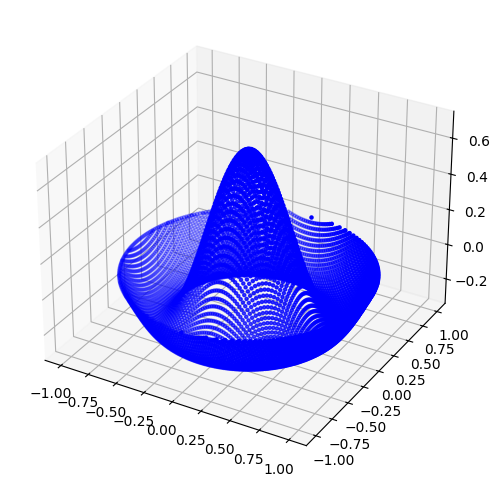

In [32]:
ik = 3
# test_num = 6
# err = np.zeros(test_num)

# Beta parameter for stability
beta = 0.6 # k=3, 0.6; k=2, 0.6; k=1, 1

DomX, DomY, g, u_naut, u_naut_t, qmax, t_init, t_final, bdy_ext, v2x, v4x, v6x, exact = Problem3()

# t_final = 
# CFL number
CFL = 1

plt.gcf().set_size_inches(6, 14)
ax2=plt.axes(projection='3d')

# for tnum in range(test_num):
# Number of grid points and boundary extension number
Nx = 100
Ny = 100
#Nc = 5 # center index for circular boundary

# Time interval
t_init = 0

# Set dx
dx = (DomX[1]-DomX[0])/Nx
dy = (DomY[1]-DomY[0])/Ny

# Generate the grid points with the ends included
x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
X, Y = meshgrid(x, y)
u01 = np.zeros_like(X)
u02 = np.zeros_like(X)

# Setup the grid points/index with circular boundary
xn = np.zeros_like(x)
xn_id = np.zeros_like(x)
xn_dx = np.zeros_like(x)
for j in range(Ny+1):
    xn[j] = np.sqrt(1-y[j]**2)  # domain from 0 to 1
    xn_id[j] = np.floor(xn[j]/dx)
    xn_dx[j] = np.abs(xn[j]-xn_id[j]*dx)
#         if (xn_dx[j] < 1/2*dx):
#             xn_dx[j]= xn_dx[j] + dx
#             xn_id[j]-=1
    if (xn_dx[j]<1e-10):
        xn_dx[j]=0
    if (dx-xn_dx[j]<1e-10):
        xn_dx[j]=0
        xn_id[j]+=1     
yn = np.zeros_like(x)
yn_id = np.zeros_like(x)
yn_dy = np.zeros_like(x)
for i in range(Nx+1):
    yn[i] = np.sqrt(1-x[i]**2)  # domain from 0 to 1
    yn_id[i] = np.floor(yn[i]/dy)
    yn_dy[i] = np.abs(yn[i]-yn_id[i]*dy)
#         if (yn_dy[j] < 1/2*dy):
#             yn_dy[j]= yn_dy[j] + dy
#             yn_id[j]-=1
    if (yn_dy[i]<1e-10):
        yn_dy[i]=0
    if (dy-yn_dy[i]<1e-10):
        yn_dy[i]=0
        yn_id[i]+=1
#     


# start_time = time.time()

Nc = int(Nx/2)

for j in range(Ny+1):
    for i in range(Nx+1):
        u01[i,j] = u_naut(x[i],y[j])

for j in range(Ny+1):
    for i in range(Nx+1):
        u02[i,j] = u_naut_t(x[i],y[j])

u1 = u01
u2 = u02

# Intialize t
t = t_init
bcu = 0

dt = set_dt_AD_2D(t,t_final,CFL,dx,0,1)

while t < t_final:

#     bcu0 = bcu
    if ik == 1:
        rhs2 = MOLT1_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x)
        u1, u2 = RK1_v(u1, u2, dt, rhs2)
    elif ik == 2:
        u01 = u1
        u02 = u2
        io = 0
        rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
        u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

        io = 1
        rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
        u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)
    elif ik == 3: 
        u01 = u1
        u02 = u2
        io = 0
        rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
        u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

        io = 1
        rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
        u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

        io = 2
        rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
        u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)
    
    t += dt    

      # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t

    for j in range(0,Ny+1):
        for i in range(0,Nx+1):
            r2 = x[i]**2 + y[j]**2
            if (r2 >= 1):
                u1[i][j] = 0
                u2[i][j] = 0

U2=u1

# end_time = time.time()
# print( 'Total time (s):',end_time - start_time )
# Error = np.zeros_like(U2)
for j in range(Ny+1):   
    n = int(xn_id[j])
    p = np.zeros(2*n+1)
    k=0
    for i in range(Nc-n, Nc+n+1):
        p[k]=x[i]
        k+=1

    if xn_dx[j]!=0:    
        n=n+1
        p2 = np.zeros(2*n+1)
        p2[1:-1] = p
        p2[ 0] = p[ 0] - xn_dx[j]
        p2[-1] = p[-1] + xn_dx[j]
        p = p2
    ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')

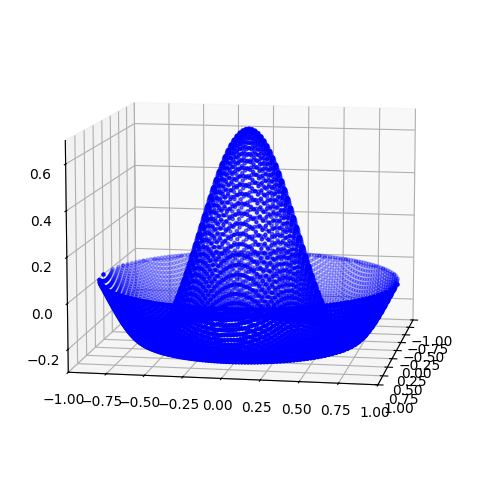

In [35]:
plt.gcf().set_size_inches(6, 14)
ax2=plt.axes(projection='3d')
for j in range(Ny+1):   
    n = int(xn_id[j])
    p = np.zeros(2*n+1)
    k=0
    for i in range(Nc-n, Nc+n+1):
        p[k]=x[i]
        k+=1

    if xn_dx[j]!=0:    
        n=n+1
        p2 = np.zeros(2*n+1)
        p2[1:-1] = p
        p2[ 0] = p[ 0] - xn_dx[j]
        p2[-1] = p[-1] + xn_dx[j]
        p = p2
    ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
ax2.view_init(10,10)
ax2.set_xlim3d(-1,1)
ax2.set_ylim3d(-1,1)
ax2.set_zlim3d(-0.3,0.7)
plt.show()

In [ ]:
# Circular boundary domain / Propagation
# Concept for dx/grid is different
# For simplicity, we separate the order of algorithm

# Scheme
ik = 3
test_num = 6
err = np.zeros(test_num)

# Beta parameter for stability
beta = 0.6 # k=3, 0.6; k=2, 0.6; k=1, 1

DomX, DomY, g, u_naut, u_naut_t, qmax, t_init, t_final, bdy_ext, v2x, v4x, v6x, exact = Problem3()

# t_final = 
# CFL number
CFL = 1

plt.gcf().set_size_inches(6, 14)
ax2=plt.axes(projection='3d')

for tnum in range(test_num):
# Number of grid points and boundary extension number
    Nx = 20*2**(tnum)
    Ny = 20*2**(tnum)
    #Nc = 5 # center index for circular boundary

    # Time interval
    t_init = 0

    # Set dx
    dx = (DomX[1]-DomX[0])/Nx
    dy = (DomY[1]-DomY[0])/Ny

    # Generate the grid points with the ends included
    x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
    y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
    X, Y = meshgrid(x, y)
    u01 = np.zeros_like(X)
    u02 = np.zeros_like(X)
    
    # Setup the grid points/index with circular boundary
    xn = np.zeros_like(x)
    xn_id = np.zeros_like(x)
    xn_dx = np.zeros_like(x)
    for j in range(Ny+1):
        xn[j] = np.sqrt(1-y[j]**2)  # domain from 0 to 1
        xn_id[j] = np.floor(xn[j]/dx)
        xn_dx[j] = np.abs(xn[j]-xn_id[j]*dx)
#         if (xn_dx[j] < 1/2*dx):
#             xn_dx[j]= xn_dx[j] + dx
#             xn_id[j]-=1
        if (xn_dx[j]<1e-10):
            xn_dx[j]=0
        if (dx-xn_dx[j]<1e-10):
            xn_dx[j]=0
            xn_id[j]+=1     
    yn = np.zeros_like(x)
    yn_id = np.zeros_like(x)
    yn_dy = np.zeros_like(x)
    for i in range(Nx+1):
        yn[i] = np.sqrt(1-x[i]**2)  # domain from 0 to 1
        yn_id[i] = np.floor(yn[i]/dy)
        yn_dy[i] = np.abs(yn[i]-yn_id[i]*dy)
#         if (yn_dy[j] < 1/2*dy):
#             yn_dy[j]= yn_dy[j] + dy
#             yn_id[j]-=1
        if (yn_dy[i]<1e-10):
            yn_dy[i]=0
        if (dy-yn_dy[i]<1e-10):
            yn_dy[i]=0
            yn_id[i]+=1
    #     


    start_time = time.time()

    Nc = int(Nx/2)

    for j in range(Ny+1):
        for i in range(Nx+1):
            u01[i,j] = u_naut(x[i],y[j])

    for j in range(Ny+1):
        for i in range(Nx+1):
            u02[i,j] = u_naut_t(x[i],y[j])

    u1 = u01
    u2 = u02

    # Intialize t
    t = t_init
    bcu = 0

    dt = set_dt_AD_2D(t,t_final,CFL,dx,0,1)

    while t < t_final:

    #     bcu0 = bcu
        if ik == 1:
            rhs2 = MOLT1_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x)
            u1, u2 = RK1_v(u1, u2, dt, rhs2)
        elif ik == 2:
            u01 = u1
            u02 = u2
            io = 0
            rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
            u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 1
            rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
            u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)
        elif ik == 3: 
            u01 = u1
            u02 = u2
            io = 0
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 1
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 2
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)
        
        t += dt    

          # End case for the integrator
        if (t + dt > t_final - 1e-10):
            dt = t_final - t

        for j in range(0,Ny+1):
            for i in range(0,Nx+1):
                r2 = x[i]**2 + y[j]**2
                if (r2 >= 1):
                    u1[i][j] = 0
                    u2[i][j] = 0

    U2=u1

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )
    Error = np.zeros_like(U2)
    for j in range(Ny+1):   
        n = int(xn_id[j])
        p = np.zeros(2*n+1)
        k=0
        for i in range(Nc-n, Nc+n+1):
            p[k]=x[i]
            k+=1

        if xn_dx[j]!=0:    
            n=n+1
            p2 = np.zeros(2*n+1)
            p2[1:-1] = p
            p2[ 0] = p[ 0] - xn_dx[j]
            p2[-1] = p[-1] + xn_dx[j]
            p = p2
#         ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
        exact1 = exact(p,y[j],t_final)
#         print(np.max(np.abs((U2[Nc-n:Nc+n+1,j] - exact1))))
#         err[tnum] = np.sum(np.abs((U2[Nc-n:Nc+n+1,j] - exact1)))
#         Error[Nc-n:Nc+n+1,j] = np.abs((U2[Nc-n:Nc+n+1,j] - exact1))
#         ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
        err[tnum] = max(err[tnum],np.max(np.abs((U2[Nc-n:Nc+n+1,j] - exact1))))
        exact1 = exact(x[j],p,t_final)
        err[tnum] = max(err[tnum],np.max(np.abs((U2[j,Nc-n:Nc+n+1] - exact1))))
    
    
#     ax2.scatter(x[j],p,U2[j,Nc-n:Nc+n+1],c='b',marker='.')  
    
# ax2.view_init(10,10)
# ax2.set_xlim3d(-1,1)
# ax2.set_ylim3d(-1,1)
# ax2.set_zlim3d(-0.2,2.3)
# plt.show()

ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err[n+1]),'&', "{:.3f}".format(ord1[n]))
# plt.pcolor(X,Y,U2)
# plt.colorbar()
# plt.show()

/tmp/local/42383453/ipykernel_3631684/2273270510.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u01[i,j] = u_naut(x[i],y[j])
/tmp/local/42383453/ipykernel_3631684/356193308.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  I_0[i] += A*np.exp(-gamma*( x[i] - x[0] )) + B*np.exp(-gamma*( x[-1] - x[i] ))
/tmp/local/42383453/ipykernel_3631684/4204921139.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_xx[i][j] = v2x(x[i],t)
/tmp/local/42383453/ipykernel_

Total time (s): 2.58345890045166
Total time (s): 15.221962213516235
Total time (s): 99.16342091560364
Total time (s): 705.703572511673
Total time (s): 5280.252222299576


In [ ]:
print(err)
ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err[n+1]),'&', "{:.3f}".format(ord1[n]))

/tmp/local/42383453/ipykernel_3631684/1005107988.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u01[i,j] = u_naut(x[i],y[j])
/tmp/local/42383453/ipykernel_3631684/356193308.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  I_0[i] += A*np.exp(-gamma*( x[i] - x[0] )) + B*np.exp(-gamma*( x[-1] - x[i] ))
/tmp/local/42383453/ipykernel_3631684/4204921139.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_xx[i][j] = v2x(x[i],t)
/tmp/local/42383453/ipykernel_

Total time (s): 10484.187952518463
<Error> & <Order>
0.00e+00 &   --
0.00e+00 & nan
0.00e+00 & nan
0.00e+00 & nan
1.09e-04 & -inf


/tmp/local/42383453/ipykernel_3631684/1005107988.py:180: RuntimeWarning: divide by zero encountered in divide
  ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
/tmp/local/42383453/ipykernel_3631684/1005107988.py:180: RuntimeWarning: invalid value encountered in divide
  ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))


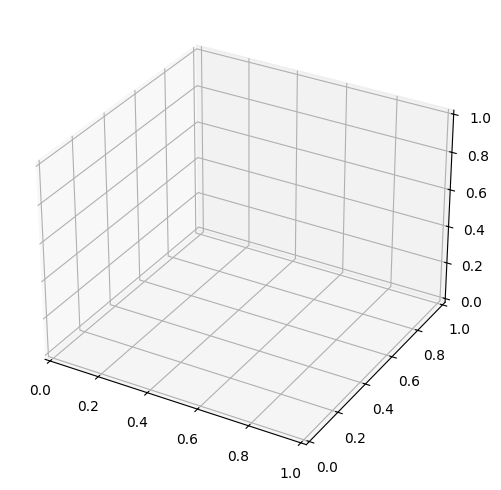

In [33]:
# Circular boundary domain / Propagation
# Concept for dx/grid is different
# For simplicity, we separate the order of algorithm

# Scheme
ik = 2
test_num = 5
err = np.zeros(test_num)

# Beta parameter for stability
beta = 0.6 # k=3, 0.6; k=2, 0.6; k=1, 1

DomX, DomY, g, u_naut, u_naut_t, qmax, t_init, t_final, bdy_ext, v2x, v4x, v6x, exact = Problem3()

# t_final = 
# CFL number
CFL = 0.5

plt.gcf().set_size_inches(6, 14)
ax2=plt.axes(projection='3d')

for tnum in range(4,test_num):
# Number of grid points and boundary extension number
    Nx = 20*2**(tnum)
    Ny = 20*2**(tnum)
    #Nc = 5 # center index for circular boundary

    # Time interval
    t_init = 0

    # Set dx
    dx = (DomX[1]-DomX[0])/Nx
    dy = (DomY[1]-DomY[0])/Ny

    # Generate the grid points with the ends included
    x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
    y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
    X, Y = meshgrid(x, y)
    u01 = np.zeros_like(X)
    u02 = np.zeros_like(X)
    
    # Setup the grid points/index with circular boundary
    xn = np.zeros_like(x)
    xn_id = np.zeros_like(x)
    xn_dx = np.zeros_like(x)
    for j in range(Ny+1):
        xn[j] = np.sqrt(1-y[j]**2)  # domain from 0 to 1
        xn_id[j] = np.floor(xn[j]/dx)
        xn_dx[j] = np.abs(xn[j]-xn_id[j]*dx)
#         if (xn_dx[j] < 1/2*dx):
#             xn_dx[j]= xn_dx[j] + dx
#             xn_id[j]-=1
        if (xn_dx[j]<1e-10):
            xn_dx[j]=0
        if (dx-xn_dx[j]<1e-10):
            xn_dx[j]=0
            xn_id[j]+=1     
    yn = np.zeros_like(x)
    yn_id = np.zeros_like(x)
    yn_dy = np.zeros_like(x)
    for i in range(Nx+1):
        yn[i] = np.sqrt(1-x[i]**2)  # domain from 0 to 1
        yn_id[i] = np.floor(yn[i]/dy)
        yn_dy[i] = np.abs(yn[i]-yn_id[i]*dy)
#         if (yn_dy[j] < 1/2*dy):
#             yn_dy[j]= yn_dy[j] + dy
#             yn_id[j]-=1
        if (yn_dy[i]<1e-10):
            yn_dy[i]=0
        if (dy-yn_dy[i]<1e-10):
            yn_dy[i]=0
            yn_id[i]+=1
    #     


    start_time = time.time()

    Nc = int(Nx/2)

    for j in range(Ny+1):
        for i in range(Nx+1):
            u01[i,j] = u_naut(x[i],y[j])

    for j in range(Ny+1):
        for i in range(Nx+1):
            u02[i,j] = u_naut_t(x[i],y[j])

    u1 = u01
    u2 = u02

    # Intialize t
    t = t_init
    bcu = 0

    dt = set_dt_AD_2D(t,t_final,CFL,dx,0,1)

    while t < t_final:

    #     bcu0 = bcu
        if ik == 1:
            rhs2 = MOLT1_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x)
            u1, u2 = RK1_v(u1, u2, dt, rhs2)
        elif ik == 2:
            u01 = u1
            u02 = u2
            io = 0
            rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
            u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 1
            rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
            u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)
        elif ik == 3: 
            u01 = u1
            u02 = u2
            io = 0
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 1
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 2
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)
        
        t += dt    

          # End case for the integrator
        if (t + dt > t_final - 1e-10):
            dt = t_final - t

        for j in range(0,Ny+1):
            for i in range(0,Nx+1):
                r2 = x[i]**2 + y[j]**2
                if (r2 >= 1):
                    u1[i][j] = 0
                    u2[i][j] = 0

    U2=u1

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )
    Error = np.zeros_like(U2)
    for j in range(Ny+1):   
        n = int(xn_id[j])
        p = np.zeros(2*n+1)
        k=0
        for i in range(Nc-n, Nc+n+1):
            p[k]=x[i]
            k+=1

        if xn_dx[j]!=0:    
            n=n+1
            p2 = np.zeros(2*n+1)
            p2[1:-1] = p
            p2[ 0] = p[ 0] - xn_dx[j]
            p2[-1] = p[-1] + xn_dx[j]
            p = p2
#         ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
        exact1 = exact(p,y[j],t_final)
#         print(np.max(np.abs((U2[Nc-n:Nc+n+1,j] - exact1))))
#         err[tnum] = np.sum(np.abs((U2[Nc-n:Nc+n+1,j] - exact1)))
#         Error[Nc-n:Nc+n+1,j] = np.abs((U2[Nc-n:Nc+n+1,j] - exact1))
#         ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
        err[tnum] = max(err[tnum],np.max(np.abs((U2[Nc-n:Nc+n+1,j] - exact1))))
        exact1 = exact(x[j],p,t_final)
        err[tnum] = max(err[tnum],np.max(np.abs((U2[j,Nc-n:Nc+n+1] - exact1))))
    
    
#     ax2.scatter(x[j],p,U2[j,Nc-n:Nc+n+1],c='b',marker='.')  
    
# ax2.view_init(10,10)
# ax2.set_xlim3d(-1,1)
# ax2.set_ylim3d(-1,1)
# ax2.set_zlim3d(-0.2,2.3)
# plt.show()

ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err[n+1]),'&', "{:.3f}".format(ord1[n]))
# plt.pcolor(X,Y,U2)
# plt.colorbar()
# plt.show()

In [37]:
# print(err[-1])
np.log(4.33e-04/err[-1])/(np.log(1/2))

-1.984047949377447

In [34]:
ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err[n+1]),'&', "{:.3f}".format(ord1[n]))


# k = 2; CFL = 0.5; N = 20*2**4; 0.00010945357489533514

<Error> & <Order>
0.00e+00 &   --
0.00e+00 & nan
0.00e+00 & nan
0.00e+00 & nan
1.09e-04 & -inf


/tmp/local/42383453/ipykernel_3631684/1988740965.py:1: RuntimeWarning: divide by zero encountered in divide
  ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
/tmp/local/42383453/ipykernel_3631684/1988740965.py:1: RuntimeWarning: invalid value encountered in divide
  ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))


In [ ]:
# Circular boundary domain / Propagation
# Concept for dx/grid is different
# For simplicity, we separate the order of algorithm

# Scheme
ik = 3
test_num = 5
err = np.zeros(test_num)

# Beta parameter for stability
beta = 0.6 # k=3, 0.6; k=2, 0.6; k=1, 1

DomX, DomY, g, u_naut, u_naut_t, qmax, t_init, t_final, bdy_ext, v2x, v4x, v6x, exact = Problem3()

# t_final = 
# CFL number
CFL = 0.5

plt.gcf().set_size_inches(6, 14)
ax2=plt.axes(projection='3d')

for tnum in range(test_num):
# Number of grid points and boundary extension number
    Nx = 20*2**(tnum)
    Ny = 20*2**(tnum)
    #Nc = 5 # center index for circular boundary

    # Time interval
    t_init = 0

    # Set dx
    dx = (DomX[1]-DomX[0])/Nx
    dy = (DomY[1]-DomY[0])/Ny

    # Generate the grid points with the ends included
    x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
    y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
    X, Y = meshgrid(x, y)
    u01 = np.zeros_like(X)
    u02 = np.zeros_like(X)
    
    # Setup the grid points/index with circular boundary
    xn = np.zeros_like(x)
    xn_id = np.zeros_like(x)
    xn_dx = np.zeros_like(x)
    for j in range(Ny+1):
        xn[j] = np.sqrt(1-y[j]**2)  # domain from 0 to 1
        xn_id[j] = np.floor(xn[j]/dx)
        xn_dx[j] = np.abs(xn[j]-xn_id[j]*dx)
#         if (xn_dx[j] < 1/2*dx):
#             xn_dx[j]= xn_dx[j] + dx
#             xn_id[j]-=1
        if (xn_dx[j]<1e-10):
            xn_dx[j]=0
        if (dx-xn_dx[j]<1e-10):
            xn_dx[j]=0
            xn_id[j]+=1     
    yn = np.zeros_like(x)
    yn_id = np.zeros_like(x)
    yn_dy = np.zeros_like(x)
    for i in range(Nx+1):
        yn[i] = np.sqrt(1-x[i]**2)  # domain from 0 to 1
        yn_id[i] = np.floor(yn[i]/dy)
        yn_dy[i] = np.abs(yn[i]-yn_id[i]*dy)
#         if (yn_dy[j] < 1/2*dy):
#             yn_dy[j]= yn_dy[j] + dy
#             yn_id[j]-=1
        if (yn_dy[i]<1e-10):
            yn_dy[i]=0
        if (dy-yn_dy[i]<1e-10):
            yn_dy[i]=0
            yn_id[i]+=1
    #     


    start_time = time.time()

    Nc = int(Nx/2)

    for j in range(Ny+1):
        for i in range(Nx+1):
            u01[i,j] = u_naut(x[i],y[j])

    for j in range(Ny+1):
        for i in range(Nx+1):
            u02[i,j] = u_naut_t(x[i],y[j])

    u1 = u01
    u2 = u02

    # Intialize t
    t = t_init
    bcu = 0

    dt = set_dt_AD_2D(t,t_final,CFL,dx,0,1)

    while t < t_final:

    #     bcu0 = bcu
        if ik == 1:
            rhs2 = MOLT1_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x)
            u1, u2 = RK1_v(u1, u2, dt, rhs2)
        elif ik == 2:
            u01 = u1
            u02 = u2
            io = 0
            rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
            u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 1
            rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
            u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)
        elif ik == 3: 
            u01 = u1
            u02 = u2
            io = 0
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 1
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 2
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)
        
        t += dt    

          # End case for the integrator
        if (t + dt > t_final - 1e-10):
            dt = t_final - t

        for j in range(0,Ny+1):
            for i in range(0,Nx+1):
                r2 = x[i]**2 + y[j]**2
                if (r2 >= 1):
                    u1[i][j] = 0
                    u2[i][j] = 0

    U2=u1

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )
    Error = np.zeros_like(U2)
    for j in range(Ny+1):   
        n = int(xn_id[j])
        p = np.zeros(2*n+1)
        k=0
        for i in range(Nc-n, Nc+n+1):
            p[k]=x[i]
            k+=1

        if xn_dx[j]!=0:    
            n=n+1
            p2 = np.zeros(2*n+1)
            p2[1:-1] = p
            p2[ 0] = p[ 0] - xn_dx[j]
            p2[-1] = p[-1] + xn_dx[j]
            p = p2
#         ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
        exact1 = exact(p,y[j],t_final)
#         print(np.max(np.abs((U2[Nc-n:Nc+n+1,j] - exact1))))
#         err[tnum] = np.sum(np.abs((U2[Nc-n:Nc+n+1,j] - exact1)))
#         Error[Nc-n:Nc+n+1,j] = np.abs((U2[Nc-n:Nc+n+1,j] - exact1))
#         ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
        err[tnum] = max(err[tnum],np.max(np.abs((U2[Nc-n:Nc+n+1,j] - exact1))))
        exact1 = exact(x[j],p,t_final)
        err[tnum] = max(err[tnum],np.max(np.abs((U2[j,Nc-n:Nc+n+1] - exact1))))
    
    
#     ax2.scatter(x[j],p,U2[j,Nc-n:Nc+n+1],c='b',marker='.')  
    
# ax2.view_init(10,10)
# ax2.set_xlim3d(-1,1)
# ax2.set_ylim3d(-1,1)
# ax2.set_zlim3d(-0.2,2.3)
# plt.show()

ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err[n+1]),'&', "{:.3f}".format(ord1[n]))
# plt.pcolor(X,Y,U2)
# plt.colorbar()
# plt.show()

In [ ]:
# Circular boundary domain / Propagation
# Concept for dx/grid is different
# For simplicity, we separate the order of algorithm

# Scheme
ik = 3
test_num = 5
err = np.zeros(test_num)

# Beta parameter for stability
beta = 0.6 # k=3, 0.6; k=2, 0.6; k=1, 1

DomX, DomY, g, u_naut, u_naut_t, qmax, t_init, t_final, bdy_ext, v2x, v4x, v6x, exact = Problem3()

# t_final = 
# CFL number
CFL = 2

plt.gcf().set_size_inches(6, 14)
ax2=plt.axes(projection='3d')

for tnum in range(test_num):
# Number of grid points and boundary extension number
    Nx = 20*2**(tnum)
    Ny = 20*2**(tnum)
    #Nc = 5 # center index for circular boundary

    # Time interval
    t_init = 0

    # Set dx
    dx = (DomX[1]-DomX[0])/Nx
    dy = (DomY[1]-DomY[0])/Ny

    # Generate the grid points with the ends included
    x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
    y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
    X, Y = meshgrid(x, y)
    u01 = np.zeros_like(X)
    u02 = np.zeros_like(X)
    
    # Setup the grid points/index with circular boundary
    xn = np.zeros_like(x)
    xn_id = np.zeros_like(x)
    xn_dx = np.zeros_like(x)
    for j in range(Ny+1):
        xn[j] = np.sqrt(1-y[j]**2)  # domain from 0 to 1
        xn_id[j] = np.floor(xn[j]/dx)
        xn_dx[j] = np.abs(xn[j]-xn_id[j]*dx)
#         if (xn_dx[j] < 1/2*dx):
#             xn_dx[j]= xn_dx[j] + dx
#             xn_id[j]-=1
        if (xn_dx[j]<1e-10):
            xn_dx[j]=0
        if (dx-xn_dx[j]<1e-10):
            xn_dx[j]=0
            xn_id[j]+=1     
    yn = np.zeros_like(x)
    yn_id = np.zeros_like(x)
    yn_dy = np.zeros_like(x)
    for i in range(Nx+1):
        yn[i] = np.sqrt(1-x[i]**2)  # domain from 0 to 1
        yn_id[i] = np.floor(yn[i]/dy)
        yn_dy[i] = np.abs(yn[i]-yn_id[i]*dy)
#         if (yn_dy[j] < 1/2*dy):
#             yn_dy[j]= yn_dy[j] + dy
#             yn_id[j]-=1
        if (yn_dy[i]<1e-10):
            yn_dy[i]=0
        if (dy-yn_dy[i]<1e-10):
            yn_dy[i]=0
            yn_id[i]+=1
    #     


    start_time = time.time()

    Nc = int(Nx/2)

    for j in range(Ny+1):
        for i in range(Nx+1):
            u01[i,j] = u_naut(x[i],y[j])

    for j in range(Ny+1):
        for i in range(Nx+1):
            u02[i,j] = u_naut_t(x[i],y[j])

    u1 = u01
    u2 = u02

    # Intialize t
    t = t_init
    bcu = 0

    dt = set_dt_AD_2D(t,t_final,CFL,dx,0,1)

    while t < t_final:

    #     bcu0 = bcu
        if ik == 1:
            rhs2 = MOLT1_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x)
            u1, u2 = RK1_v(u1, u2, dt, rhs2)
        elif ik == 2:
            u01 = u1
            u02 = u2
            io = 0
            rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
            u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 1
            rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
            u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)
        elif ik == 3: 
            u01 = u1
            u02 = u2
            io = 0
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 1
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)

            io = 2
            rhs2 = MOLT3_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,v6x,io)
            u1, u2 = RK3_v(io, u01, u02, u1, u2, dt, rhs2)
        
        t += dt    

          # End case for the integrator
        if (t + dt > t_final - 1e-10):
            dt = t_final - t

        for j in range(0,Ny+1):
            for i in range(0,Nx+1):
                r2 = x[i]**2 + y[j]**2
                if (r2 >= 1):
                    u1[i][j] = 0
                    u2[i][j] = 0

    U2=u1

    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )
    Error = np.zeros_like(U2)
    for j in range(Ny+1):   
        n = int(xn_id[j])
        p = np.zeros(2*n+1)
        k=0
        for i in range(Nc-n, Nc+n+1):
            p[k]=x[i]
            k+=1

        if xn_dx[j]!=0:    
            n=n+1
            p2 = np.zeros(2*n+1)
            p2[1:-1] = p
            p2[ 0] = p[ 0] - xn_dx[j]
            p2[-1] = p[-1] + xn_dx[j]
            p = p2
#         ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
        exact1 = exact(p,y[j],t_final)
#         print(np.max(np.abs((U2[Nc-n:Nc+n+1,j] - exact1))))
#         err[tnum] = np.sum(np.abs((U2[Nc-n:Nc+n+1,j] - exact1)))
#         Error[Nc-n:Nc+n+1,j] = np.abs((U2[Nc-n:Nc+n+1,j] - exact1))
#         ax2.scatter(p,y[j],U2[Nc-n:Nc+n+1,j],c='b',marker='.')
        err[tnum] = max(err[tnum],np.max(np.abs((U2[Nc-n:Nc+n+1,j] - exact1))))
        exact1 = exact(x[j],p,t_final)
        err[tnum] = max(err[tnum],np.max(np.abs((U2[j,Nc-n:Nc+n+1] - exact1))))
    
    
#     ax2.scatter(x[j],p,U2[j,Nc-n:Nc+n+1],c='b',marker='.')  
    
# ax2.view_init(10,10)
# ax2.set_xlim3d(-1,1)
# ax2.set_ylim3d(-1,1)
# ax2.set_zlim3d(-0.2,2.3)
# plt.show()

ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err[0]), '&   --')
for n in range(test_num-1):
    print("{:.2e}".format(err[n+1]),'&', "{:.3f}".format(ord1[n]))
# plt.pcolor(X,Y,U2)
# plt.colorbar()
# plt.show()

## plot

Total time (s): 121.7070620059967
Total time (s): 213.54568123817444
Total time (s): 403.32995080947876


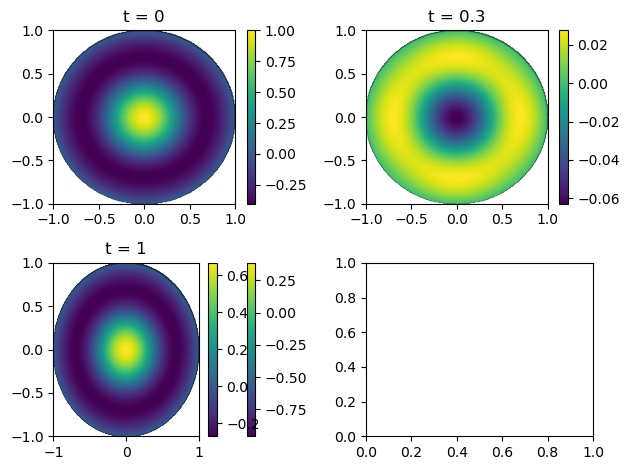

In [293]:
# Circular boundary domain / Propagation
# Concept for dx/grid is different
# For simplicity, we separate the order of algorithm

# Scheme
ik = 3
test_num = 1
# err = np.zeros(test_num)

# Beta parameter for stability
beta = 0.6

DomX, DomY, g, u_naut, u_naut_t, qmax, t_init, t_final, bdy_ext, v2x, v4x, exact = Problem3()

# CFL number
CFL = 1

# plt.gcf().set_size_inches(6, 14)
# ax2=plt.axes(projection='3d')
fig, axs = plt.subplots(nrows=2, ncols=2)

# for tnum in range(test_num):
# Number of grid points and boundary extension number
Nx = 200
Ny = 200
#Nc = 5 # center index for circular boundary

# Time interval
t_init = 0

# Set dx
dx = (DomX[1]-DomX[0])/Nx
dy = (DomY[1]-DomY[0])/Ny

# Generate the grid points with the ends included
x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
X, Y = meshgrid(x, y)
u01 = np.zeros_like(X)
u02 = np.zeros_like(X)

# Setup the grid points/index with circular boundary
xn = np.zeros_like(x)
xn_id = np.zeros_like(x)
xn_dx = np.zeros_like(x)
for j in range(Ny+1):
    xn[j] = np.sqrt(1-y[j]**2)  # domain from 0 to 1
    xn_id[j] = np.floor(xn[j]/dx)
    xn_dx[j] = np.abs(xn[j]-xn_id[j]*dx)
#         if (xn_dx[j] < 1/2*dx):
#             xn_dx[j]= xn_dx[j] + dx
#             xn_id[j]-=1
    if (xn_dx[j]<1e-10):
        xn_dx[j]=0
    if (dx-xn_dx[j]<1e-10):
        xn_dx[j]=0
        xn_id[j]+=1     
yn = np.zeros_like(x)
yn_id = np.zeros_like(x)
yn_dy = np.zeros_like(x)
for i in range(Nx+1):
    yn[i] = np.sqrt(1-x[i]**2)  # domain from 0 to 1
    yn_id[i] = np.floor(yn[i]/dy)
    yn_dy[i] = np.abs(yn[i]-yn_id[i]*dy)
#         if (yn_dy[j] < 1/2*dy):
#             yn_dy[j]= yn_dy[j] + dy
#             yn_id[j]-=1
    if (yn_dy[i]<1e-10):
        yn_dy[i]=0
    if (dy-yn_dy[i]<1e-10):
        yn_dy[i]=0
        yn_id[i]+=1
#     


start_time = time.time()

Nc = int(Nx/2)

for j in range(Ny+1):
    for i in range(Nx+1):
        u01[i,j] = u_naut(x[i],y[j])

for j in range(Ny+1):
    for i in range(Nx+1):
        u02[i,j] = u_naut_t(x[i],y[j])

Zm = np.ma.masked_where(X**2+Y**2 > 1, u01)
a11 = axs[0][0].pcolormesh(X,Y,Zm,shading='gouraud')
axs[0][0].set_title('t = 0')
fig.colorbar(a11)
# plt.show()

u1 = u01
u2 = u02

# Intialize t
t = t_init
bcu = 0

dt = set_dt_AD_2D(t,t_final,CFL,dx,0,1)

while t < t_final:

## ik = 2
    u01 = u1
    u02 = u2
    io = 0
    rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
    u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

    io = 1
    rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
    u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

## ik = 3

    t += dt    

      # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t

    for j in range(0,Ny+1):
        for i in range(0,Nx+1):
            r2 = x[i]**2 + y[j]**2
            if (r2 >= 1):
                u1[i][j] = 0
                u2[i][j] = 0

U1=u1

end_time = time.time()
print( 'Total time (s):',end_time - start_time )

Zm = np.ma.masked_where(X**2+Y**2 > 1, U1)
a12 = axs[0][1].pcolormesh(X,Y,Zm,shading='gouraud')
axs[0][1].set_title('t = 0.3')
fig.colorbar(a12)


##################################################\
start_time = time.time()

Nc = int(Nx/2)

for j in range(Ny+1):
    for i in range(Nx+1):
        u01[i,j] = u_naut(x[i],y[j])

for j in range(Ny+1):
    for i in range(Nx+1):
        u02[i,j] = u_naut_t(x[i],y[j])

u1 = u01
u2 = u02

# Intialize t
t = t_init
t_final = 0.525

dt = set_dt_AD_2D(t,t_final,CFL,dx,0,1)

while t < t_final:

## ik = 2
    u01 = u1
    u02 = u2
    io = 0
    rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
    u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

    io = 1
    rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
    u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

## ik = 3

    t += dt    

      # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t

    for j in range(0,Ny+1):
        for i in range(0,Nx+1):
            r2 = x[i]**2 + y[j]**2
            if (r2 >= 1):
                u1[i][j] = 0
                u2[i][j] = 0

U2=u1

end_time = time.time()
print( 'Total time (s):',end_time - start_time )

Zm = np.ma.masked_where(X**2+Y**2 > 1, U2)
a21 = axs[1][0].pcolormesh(X,Y,Zm,shading='gouraud')
axs[1][0].set_title('t = 0.525')
fig.colorbar(a21)

##################################################\
start_time = time.time()

Nc = int(Nx/2)

for j in range(Ny+1):
    for i in range(Nx+1):
        u01[i,j] = u_naut(x[i],y[j])

for j in range(Ny+1):
    for i in range(Nx+1):
        u02[i,j] = u_naut_t(x[i],y[j])

u1 = u01
u2 = u02

# Intialize t
t = t_init
t_final = 1

dt = set_dt_AD_2D(t,t_final,CFL,dx,0,1)

while t < t_final:

## ik = 2
    u01 = u1
    u02 = u2
    io = 0
    rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
    u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

    io = 1
    rhs2 = MOLT2_dir_xx(u1,x,y,xn,xn_id,xn_dx,yn,yn_id,yn_dy,g,bdy_ext,dx,dy,dt,CFL,beta,qmax,t,v2x,v4x,io)
    u1, u2 = RK2_v(io, u01, u02, u1, u2, dt, rhs2)

## ik = 3

    t += dt    

      # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t

    for j in range(0,Ny+1):
        for i in range(0,Nx+1):
            r2 = x[i]**2 + y[j]**2
            if (r2 >= 1):
                u1[i][j] = 0
                u2[i][j] = 0

U3=u1

end_time = time.time()
print( 'Total time (s):',end_time - start_time )

Zm = np.ma.masked_where(X**2+Y**2 > 1, U3)
a22 = axs[1][1].pcolormesh(X,Y,Zm,shading='gouraud')
axs[1][1].set_title('t = 1')
fig.colorbar(a22)

fig.tight_layout()
plt.show()

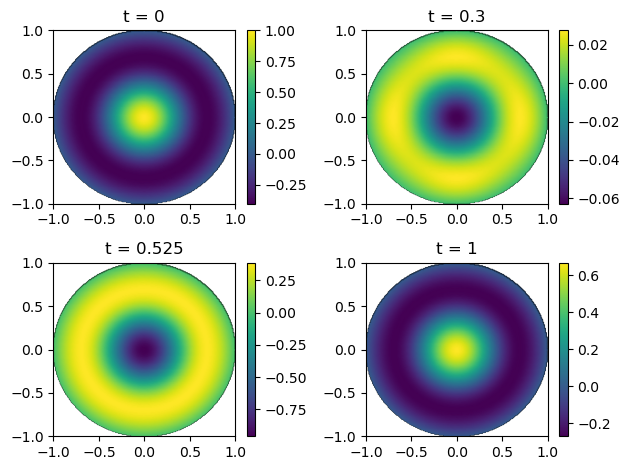

In [296]:
for j in range(Ny+1):
    for i in range(Nx+1):
        u01[i,j] = u_naut(x[i],y[j])
        
fig, axs = plt.subplots(nrows=2, ncols=2)        
        
Zm = np.ma.masked_where(X**2+Y**2 > 1, u01)
a11 = axs[0][0].pcolormesh(X,Y,Zm,shading='gouraud')
axs[0][0].set_title('t = 0')
fig.colorbar(a11) 

Zm = np.ma.masked_where(X**2+Y**2 > 1, U1)
a12 = axs[0][1].pcolormesh(X,Y,Zm,shading='gouraud')
axs[0][1].set_title('t = 0.3')
fig.colorbar(a12)

Zm = np.ma.masked_where(X**2+Y**2 > 1, U2)
a21 = axs[1][0].pcolormesh(X,Y,Zm,shading='gouraud')
axs[1][0].set_title('t = 0.525')
fig.colorbar(a21)

Zm = np.ma.masked_where(X**2+Y**2 > 1, U3)
a22 = axs[1][1].pcolormesh(X,Y,Zm,shading='gouraud')
axs[1][1].set_title('t = 1')
fig.colorbar(a22)

fig.tight_layout()
plt.show()

In [42]:
err = np.array([0.03258325, 0.00628357, 0.00110971, 0.00019113])
ord1=(np.log(err[1:None]/err[0:-1]))/(np.log(1/2))
print(err)
print(ord1)

# k = 1, CFL = 1; beta = 1; [0.88704153 0.45400432 0.22300966 0.11161148 0.        ]
# [0.96629562 1.02559984 0.9986208         inf]

# k= 2, CFL = 1, beta = 0.6
# [0.07426721 0.02274795 0.0063477  0.00167477 0.        ]
# [1.7069889  1.84143057 1.92226698        inf]

# k =3, CFL = 1, beta =0.6
# [0.03258325 0.00628357 0.00110971 0.00019113]
# [2.37447415 2.50140293]

[0.03258325 0.00628357 0.00110971 0.00019113]
[2.37447415 2.50140175 2.53755656]


/var/folders/tt/7q03vkrj25bb43b42ghxfjsc0000gn/T/ipykernel_875/2443188423.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uu2[Nc-n+i,j] = jn(0,j0_roots*np.sqrt(p[i]**2+y[j]**2))*np.cos(j0_roots*t_final)


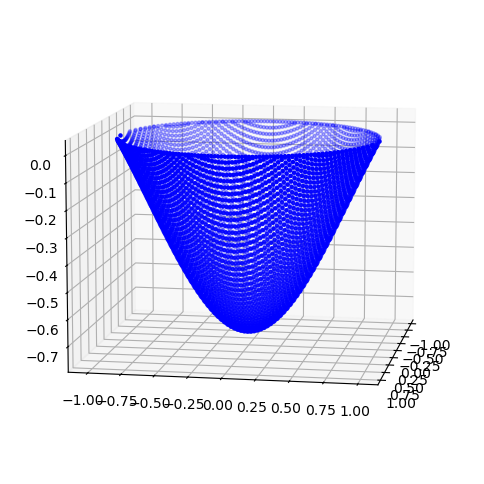

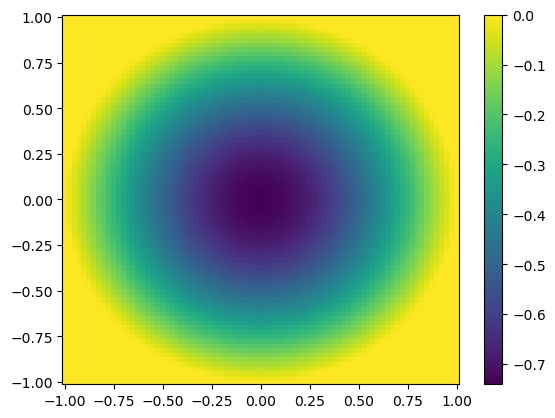

In [27]:
from scipy.special import jn, jn_zeros
# order_bessel = 100
j0_roots = jn_zeros(0, 1)
t_final = 1

plt.gcf().set_size_inches(6, 14)
ax2=plt.axes(projection='3d')

uu2 = np.zeros_like(X)
for j in range(Ny+1):   
    n = int(xn_id[j])
    p = np.zeros(2*n+1)
    k=0
    for i in range(Nc-n, Nc+n+1):
        p[k]=x[i]
        k+=1

    if xn_dx[j]!=0:    
        n=n+1
        p2 = np.zeros(2*n+1)
        p2[1:-1] = p
        p2[ 0] = p[ 0] - xn_dx[j]
        p2[-1] = p[-1] + xn_dx[j]
        p = p2
#     r = np.sqrt(x[Nc-n:Nc+n+1]**2 + y[j]**2)
#     for i in range(order_bessel):
#         U2[Nc-n:Nc+n+1,j] += 2 * np.sin(t_final*j0_roots[i]) * jn(0,j0_roots[i]*r)/j0_roots[i]/jn(0,j0_roots[i])
    
    for i in range(2*n+1):
        uu2[Nc-n+i,j] = jn(0,j0_roots*np.sqrt(p[i]**2+y[j]**2))*np.cos(j0_roots*t_final) 
#         + \
#                         1/j0_roots[0]*jn(0,j0_roots[0]*np.sqrt(p[i]**2+y[j]**2))*np.sin(j0_roots[0]*t_final) -\
#                         1/j0_roots[1]*jn(0,j0_roots[1]*np.sqrt(p[i]**2+y[j]**2))*np.sin(j0_roots[1]*t_final)
    ax2.scatter(p,y[j],uu2[Nc-n:Nc+n+1,j],c='b',marker='.')
#     ax2.scatter(x[j],p,U2[j,Nc-n:Nc+n+1],c='b',marker='.') 
# for j in range(Ny+1):   
#     n = int(xn_id[j])
#     p = np.zeros(2*n+1)
#     k=0
#     for i in range(Nc-n, Nc+n+1):
#         p[k]=x[i]
#         k+=1

#     if xn_dx[j]!=0:    
#         n=n+1
#         p2 = np.zeros(2*n+1)
#         p2[1:-1] = p
#         p2[ 0] = p[ 0] - xn_dx[j]
#         p2[-1] = p[-1] + xn_dx[j]
#         p = p2
# #     r = np.sqrt(x[Nc-n:Nc+n+1]**2 + y[j]**2)
# #     for i in range(order_bessel):
# #         U2[Nc-n:Nc+n+1,j] += 2 * np.sin(t_final*j0_roots[i]) * jn(0,j0_roots[i]*r)/j0_roots[i]/jn(0,j0_roots[i])
    
#     for i in range(2*n+1):
#         U2[j,Nc-n+i] = 2*jn(0,j0_roots[2]*np.sqrt(p[i]**2+x[j]**2))*np.cos(j0_roots[2]*t_final) + \
#                         1/j0_roots[0]*jn(0,j0_roots[0]*np.sqrt(p[i]**2+x[j]**2))*np.sin(j0_roots[0]*t_final) -\
#                         1/j0_roots[1]*jn(0,j0_roots[1]*np.sqrt(p[i]**2+x[j]**2))*np.sin(j0_roots[1]*t_final)
#     ax2.scatter(x[j],p,U2[j,Nc-n:Nc+n+1],c='b',marker='.') 
    
ax2.view_init(10,10)
# # ax2.set_xlim3d(-1,1)
# # ax2.set_ylim3d(-1,1)
# # ax2.set_zlim3d(-0.2,2.3)
plt.show()
plt.pcolor(X,Y,uu2)
plt.colorbar()
plt.show()

In [151]:
# def exact(x,y,t):
#     exact = jn(0,j0_roots[0]*np.sqrt(x**2+y**2))*np.cos(j0_roots[0]*t) 
#     return exact

a = np.array([2,3,4,5,6])
b = 7

exact(a,b,2)

array([-0.00989534,  0.00436668,  0.0170333 ,  0.00853255, -0.01347836])

In [263]:
j0_roots = jn_zeros(0, 3)
j0_roots[1]

5.520078110286311

/var/folders/tt/7q03vkrj25bb43b42ghxfjsc0000gn/T/ipykernel_875/1229573768.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u01[i,j] = u_naut(x[i],y[j])


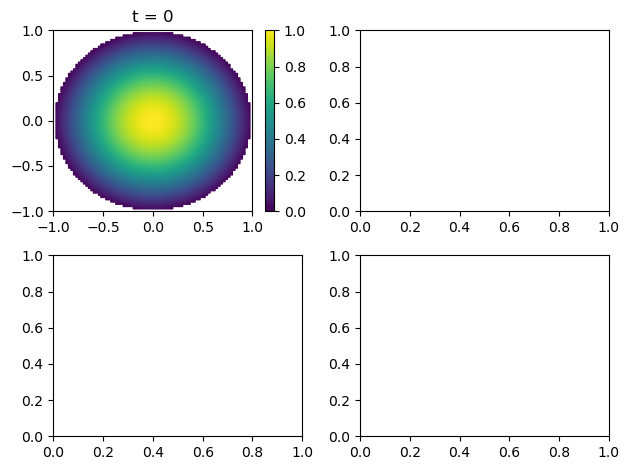

In [30]:
u01 = np.zeros_like(X)
for j in range(Ny+1):
    for i in range(Nx+1):
        u01[i,j] = u_naut(x[i],y[j])

# uu1 = np.zeros_like(X)
# uu2 = np.zeros_like(X)
# uu3 = np.zeros_like(X)
# for j in range(Ny+1):   
#     n = int(xn_id[j])
#     p = np.zeros(2*n+1)
#     k=0
#     for i in range(Nc-n, Nc+n+1):
#         p[k]=x[i]
#         k+=1

#     if xn_dx[j]!=0:    
#         n=n+1
#         p2 = np.zeros(2*n+1)
#         p2[1:-1] = p
#         p2[ 0] = p[ 0] - xn_dx[j]
#         p2[-1] = p[-1] + xn_dx[j]
#         p = p2    
#     for i in range(2*n+1):
#         uu1[Nc-n+i,j] = jn(0,j0_roots[1]*np.sqrt(p[i]**2+y[j]**2))*np.cos(j0_roots[1]*0.3) 
#         uu2[Nc-n+i,j] = jn(0,j0_roots[1]*np.sqrt(p[i]**2+y[j]**2))*np.cos(j0_roots[1]*0.525)
#         uu3[Nc-n+i,j] = jn(0,j0_roots[1]*np.sqrt(p[i]**2+y[j]**2))*np.cos(j0_roots[1])
        
fig, axs = plt.subplots(nrows=2, ncols=2)        
        
Zm = np.ma.masked_where(X**2+Y**2 > 1, u01)
a11 = axs[0][0].pcolormesh(X,Y,Zm,shading='gouraud')
axs[0][0].set_title('t = 0')
fig.colorbar(a11) 

# Zm = np.ma.masked_where(X**2+Y**2 > 1, uu1)
# a12 = axs[0][1].pcolormesh(X,Y,Zm,shading='gouraud')
# axs[0][1].set_title('t = 0.3')
# fig.colorbar(a12)

# Zm = np.ma.masked_where(X**2+Y**2 > 1, uu2)
# a21 = axs[1][0].pcolormesh(X,Y,Zm,shading='gouraud')
# axs[1][0].set_title('t = 0.525')
# fig.colorbar(a21)

# Zm = np.ma.masked_where(X**2+Y**2 > 1, uu3)
# a22 = axs[1][1].pcolormesh(X,Y,Zm,shading='gouraud')
# axs[1][1].set_title('t = 1')
# fig.colorbar(a22)

fig.tight_layout()
plt.show()

In [35]:
i = 1
j = 1
x[i]
y[j]
u_naut(x[i],y[j])
u01[i,j] = u_naut(x[i],y[j])
# u01[i,j] = u_naut(x[i],y[j])

/var/folders/tt/7q03vkrj25bb43b42ghxfjsc0000gn/T/ipykernel_875/2370754660.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u01[i,j] = u_naut(x[i],y[j])
